# Lista 2 - Alexandre Nunes
COE718 - Proc. Adaptativo de Sinais

In [1]:
# bibliotecas úteis
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

from scipy import signal

### Implementação do Algoritmo LMS

In [555]:
import numpy as np

class LMS:
    """
    Description
    ---------
    
    Implements the Complex LMS algorithm for COMPLEX valued data.
    (Algorithm 3.2 - book: Adaptive Filtering: Algorithms and Practical Implementation, Diniz)
    
    Author: Alexandre Henrique da Silva Nunes
    Based on Matlab code by Markus Vinícius Santos Limas available at 
    https://www.mathworks.com/matlabcentral/fileexchange/3582-adaptive-filtering
    
    Methods
    ---------
    fit :
        update filter params based on a desired signal and inputs.
    """
    
    def __init__(self, filter_order_num, initial_coefficients):
        """
        Inputs
        -------
        
        filter_order_num : int
                    Order of the FIR filter
        initial_coefficients : numpy array (collumn vector)
                    initial filter coefficients
                
                    
        Variables
        --------
        num_of_coefficients : int
            FIR filter number of coefficients.
        
        errors_vector : numpy array
            FIR error vectors. error_vector[k] represents the output erros at iteration k.
        outputs_vector : numpy array (collumn vector)
            Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
        coefficients_mtx : numpy array
            Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)
        """
        
        self.filter_order_num = filter_order_num
        self.num_of_coefficients = self.filter_order_num + 1
        
        self.errors_vector = np.array([0])
        self.outputs_vector = np.array([0])
        self.coefficients_mtx = np.array(initial_coefficients)
        
    def fit(self, desired, x, step):
        """
        Fit filter parameters to considering desired vector and input x. desired and x must have length K,
        where K is the number of iterations
        
        Inputs
        -------
        
        desired : numpy array (row vector)
            desired signal
        x : numpy array (row vector)
            input signal to feed filter
        step : Convergence (relaxation) factor.
        
        Outputs
        -------
        
        python dic :
            outputs : numpy array (collumn vector)
                Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
            errors : numpy array (collumn vector)
                FIR error vectors. error_vector[k] represents the output erros at iteration k.
            coefficients_mtx : numpy array
                Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)      
        """
        
        k_max = self._dim(desired)
        self._initialize_vars(k_max)
        
        for k in range(k_max):
            x_k = LMS.tapped_x(x, self.num_of_coefficients, k)
            w_k = self.coefficients_mtx[:, k]
            y_k = np.dot(LMS._conj(w_k), x_k)
            err_k = desired[k] - y_k
#             print('iteração %i' % k)
#             print('')
#             print('x_k: ', x_k)
#             print('w_k: ', w_k)
#             print('y_k: ', y_k)
#             print('err_k: ', err_k)
            
            next_w_k = w_k + step * LMS._conj(err_k) * x_k
            
            self._update(err_k, y_k, next_w_k, k)
            
        return {
            'outputs': self.outputs_vector,
            'errors': self.errors_vector,
            'coefficients': self.coefficients_mtx
        }
        
    def _initialize_vars(self, k_max):
        self.errors_vector = np.zeros((k_max, 1))
        self.outputs_vector = np.zeros((k_max, 1))
        
        initial_coefficients = self.coefficients_mtx[:, [0]]
        self.coefficients_mtx = np.append(initial_coefficients, np.zeros((self.num_of_coefficients, k_max)), axis=1)
    
    def _update(self, err, y, next_w, k):
        self.errors_vector[k, 0] = err
        self.outputs_vector[k, 0] = y
        self.coefficients_mtx[:, k+1] = np.transpose(next_w)
    
    @staticmethod
    def tapped_x(x, window, k):
        prefixed_input = LMS._range_x(x, k-window+1, k+1)
        return prefixed_input[::-1]
    
    @staticmethod
    def _x(x, index):
        if index < 0: return 0;
        return x[index]
    
    # Improve source code regularity
    @staticmethod
    def _range_x(x, start, length):
        sub_x = [LMS._x(x, start)]
        for it in range(start+1, length):
            sub_x = np.append(sub_x, LMS._x(x, it))
        return sub_x
    
    @staticmethod
    def _dim(vec):
        return vec.shape[0]
    
    @staticmethod
    def _conj(vec):
        return np.conjugate(vec)

## Questão 2

### Item a

$x(k) = -0.85x(k-1) + n(k)$

O sistema está na forma

$x(k) = -a_1x(k-1) + n(k)$

Pelo exemplo 2.1, a correlação é dada por

$r(l) = \dfrac{(-a_1)^{|l|}}{1-a_1^2}\cdot \sigma_n^2 = \dfrac{(-0.85)^{|l|}}{1-0.85^2}\cdot 0.3$

In [47]:
def r(l):
    return ((-.85) ** abs(l))/(1-(.85) ** 2) * 0.3

Portanto, para o caso 2x2

In [48]:
R = np.array([[r(0), r(1)], [r(-1), r(0)]])
print(R)

[[ 1.08108108 -0.91891892]
 [-0.91891892  1.08108108]]


Considerando que o sinal desejado é da forma $d(k) = x(k+l)$, o vetor $\vec{p}$ será

$\vec{p} = E[d(k)\vec{x}(k)] = E[x(k+l)[x(k)\hspace{2mm} x(k-1)]^T] = [r(l)\hspace{2mm} r(l-1)]^T$

Portanto, para $l=1$

In [49]:
p = np.array([[r(1)], [r(2)]])
print(p)

[[-0.91891892]
 [ 0.78108108]]


Portanto, a solução de Wiener será

$\vec{w_o} = R^{-1} \vec{p}$

In [50]:
wo = np.dot(LA.inv(R), p) 
print(wo)

[[-0.85]
 [ 0.  ]]


### Item b

Pela equação 3.30

$0 < \mu < \dfrac{1}{tr[R]}$

Portanto $\mu_{max}$ é 

In [51]:
mu_max = 1/np.trace(R)
print(mu_max)

0.4625000000000002


Assumindo $\mu = 0.2$

In [52]:
mu = .2

Configura-se o problema para 100 iterações

In [53]:
kmax = 100

def perform_fit_ex2():
    # Ruído Branco
    n_mean = 0
    n_var = 0.3
    n = np.random.normal(n_mean, np.sqrt(n_var), size=kmax)

    # wo
    wo = np.array([[-0.85], [0]])

    # Entrada
    def set_x(x0, kmax):
        x = np.array([x0])
        for k in range(1, kmax):
            x = np.append(x, [-0.85 * x[k-1] + n[k]])
        return x

    x = set_x(0, kmax)

    # Valor desejado
    def set_d(wo, x, kmax):
        d = np.array([0])
        for k in range(1, kmax):
            tapped_x = LMS.tapped_x(x, wo.shape[0], k)
            d = np.append(d, np.dot(tapped_x, wo))
        return d

    d = set_d(wo, x, kmax)

    # Filtro
    w0 = np.array([[0], [0]])
    adaptive_filter = LMS(1, w0)
    results = adaptive_filter.fit(d, x, 0.2)
    return results

results = perform_fit_ex2()
errors = results['errors']
coefficients = results['coefficients']
outputs = results['outputs']

O erro MSE é dado pela equação 2.90

$MSE = E[d^2(k)] - 2\vec{w}^T\vec{p} + \vec{w}^TR\vec{w}$

In [54]:
def MSE(w, R, p):
    return r(0) - 2 * np.dot(w.T, p) + np.dot(np.dot(w.T, R), w)

Portanto, o caminho de convergência será

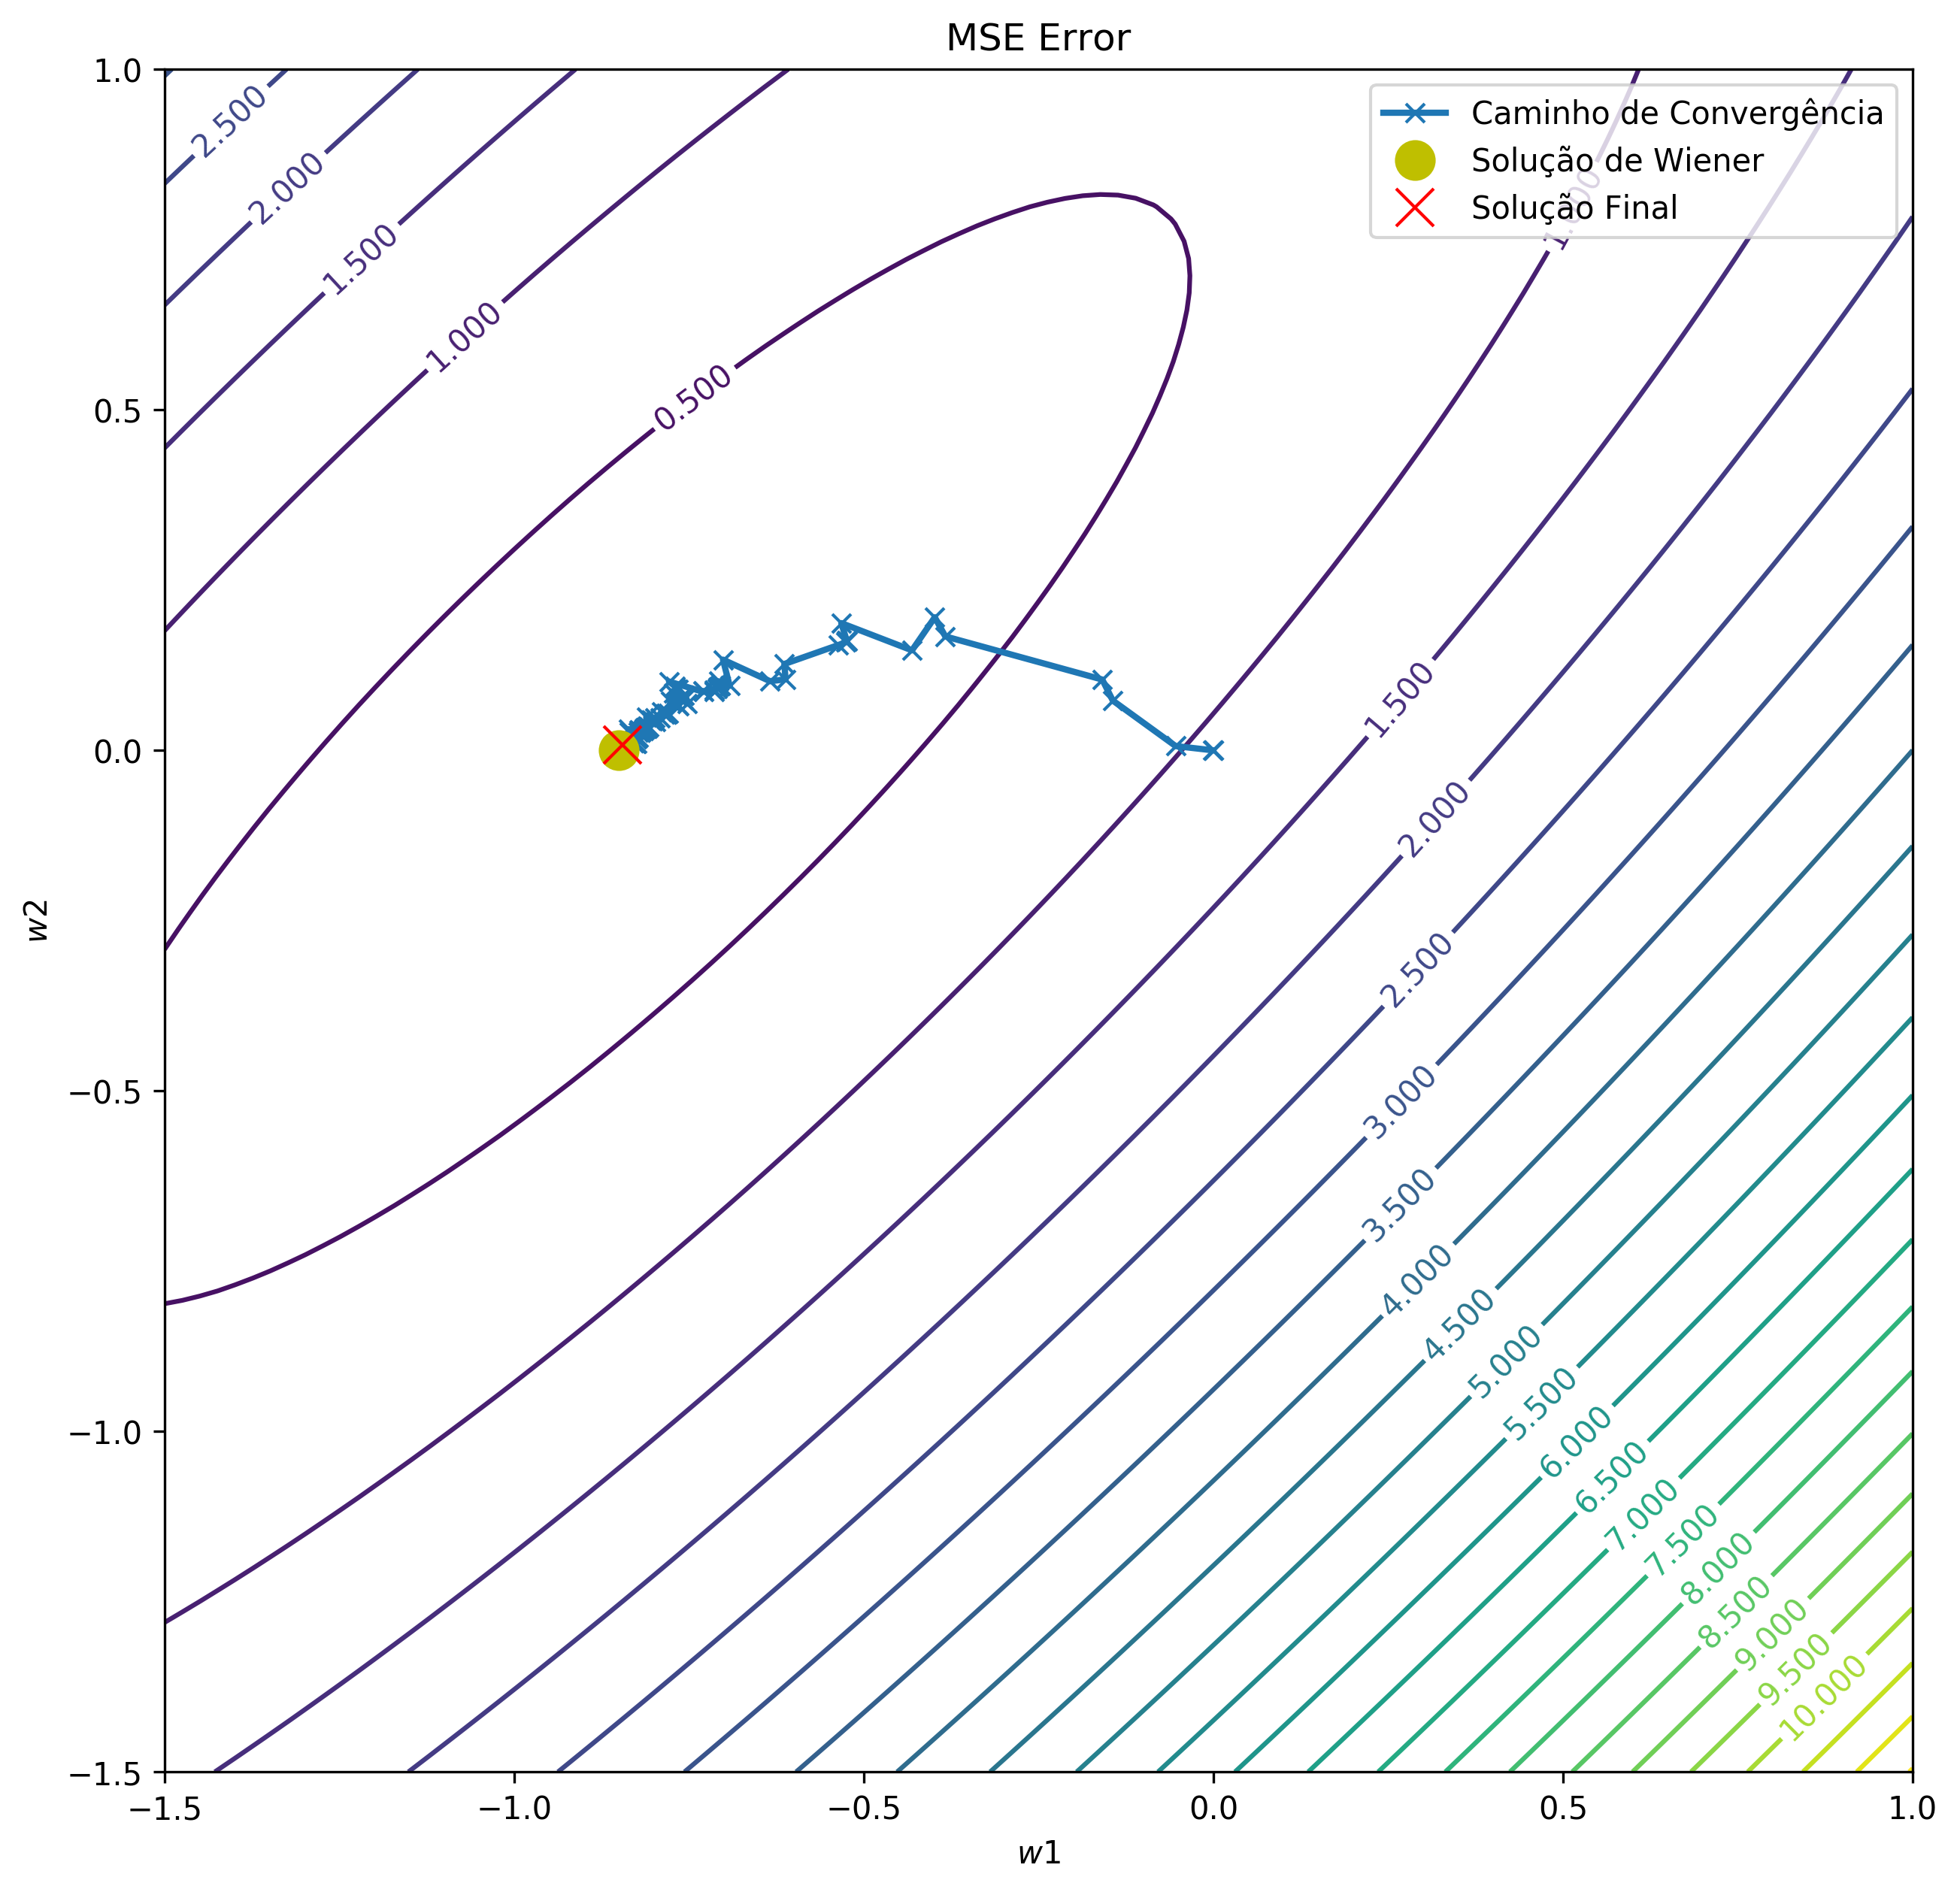

In [55]:
w1 = np.linspace(-1.5, 1, 100)
w2 = np.linspace(-1.5, 1, 100)

MSE_err = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        wj = w2[j]
        wi = w1[i]
        w = np.array([[wj], [wi]])
        MSE_err[i][j] = MSE(w, R, p)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10), dpi=300)        

# Curva de Nível
ct = ax.contour(w1, w2, MSE_err, levels=np.arange(0, np.max(MSE_err), 0.5))
ax.clabel(ct, ct.levels)

# Caminho dos coeficientes
ax.plot(coefficients[0, :], coefficients[1, :], '-x', label='Caminho de Convergência', linewidth=2, markersize=6)

# Wiener
ax.plot(wo[0], wo[1], 'o', color='y', markersize=12, label='Solução de Wiener')

# Solução final
ax.plot(coefficients[0, -1], coefficients[1, -1], 'x', label='Solução Final', color='r', markersize=12, linewidth=2)

ax.legend()
ax.set_xlabel('$w1$')
ax.set_ylabel('$w2$')
ax.set_title('MSE Error')
fig.savefig('lista2_2b.pdf', bbox_inches = 'tight')

### Item c

Usando o item b, plota-se a curva de aprendizado para uma realização

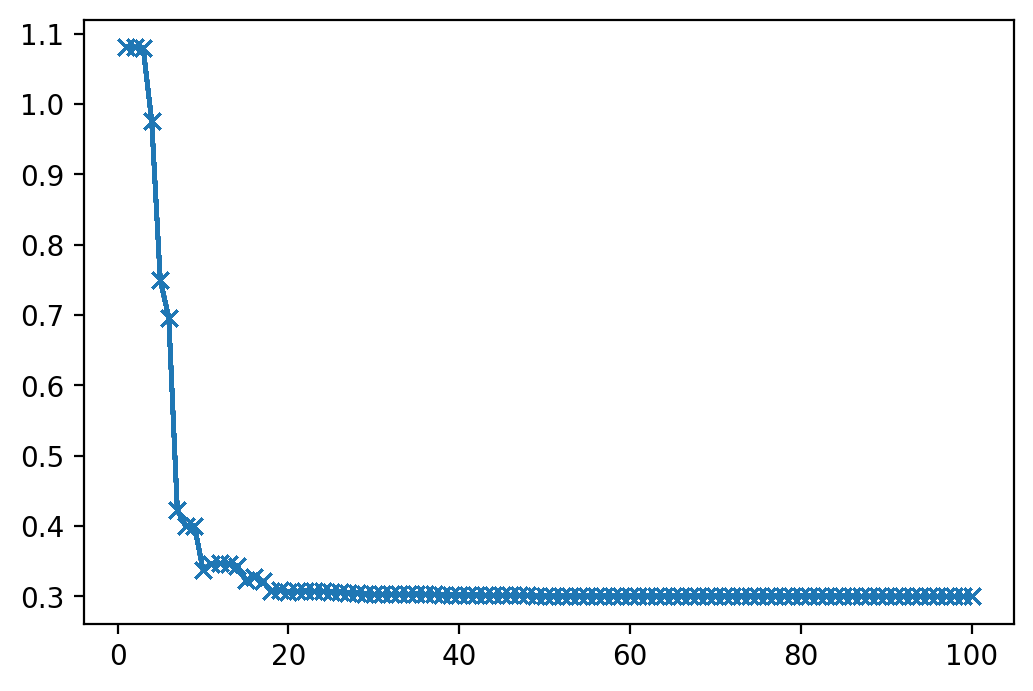

In [56]:
MSE_err_k = np.zeros(100)
for k in range(kmax):
    w2 = coefficients[0, k]
    w1 = coefficients[1, k]
    w = np.array([[w2], [w1]])
    MSE_err[k] = MSE(w, R, p)
    
    
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, 100, 100), MSE_err, color='#1f77b4', marker='x')
fig.savefig('lista2_2c1.pdf', bbox_inches = 'tight')

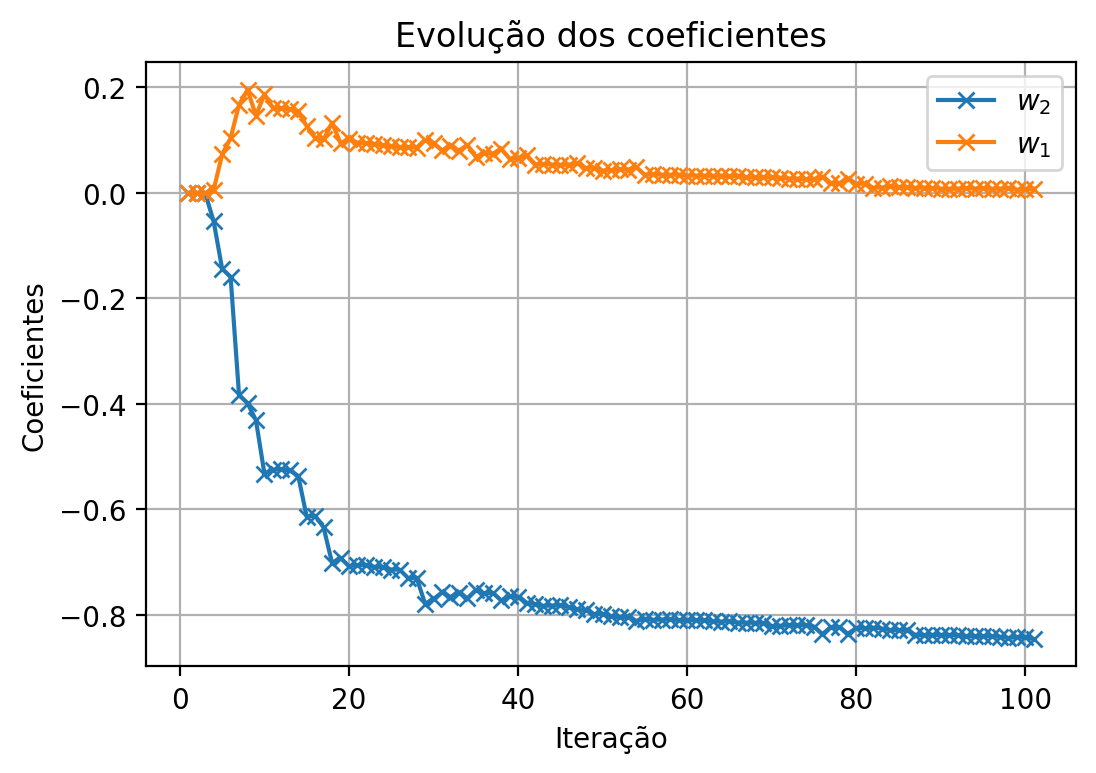

In [57]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, 101, 101), coefficients[0, :], color='#1f77b4', marker='x', label='$w_2$')
ax.plot(np.linspace(1, 101, 101), coefficients[1, :], color='#ff7f0e', marker='x', label='$w_1$')

ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolução dos coeficientes')
fig.savefig('lista2_2c3.pdf', bbox_inches = 'tight')

Para 25 realizações, obtendo a média

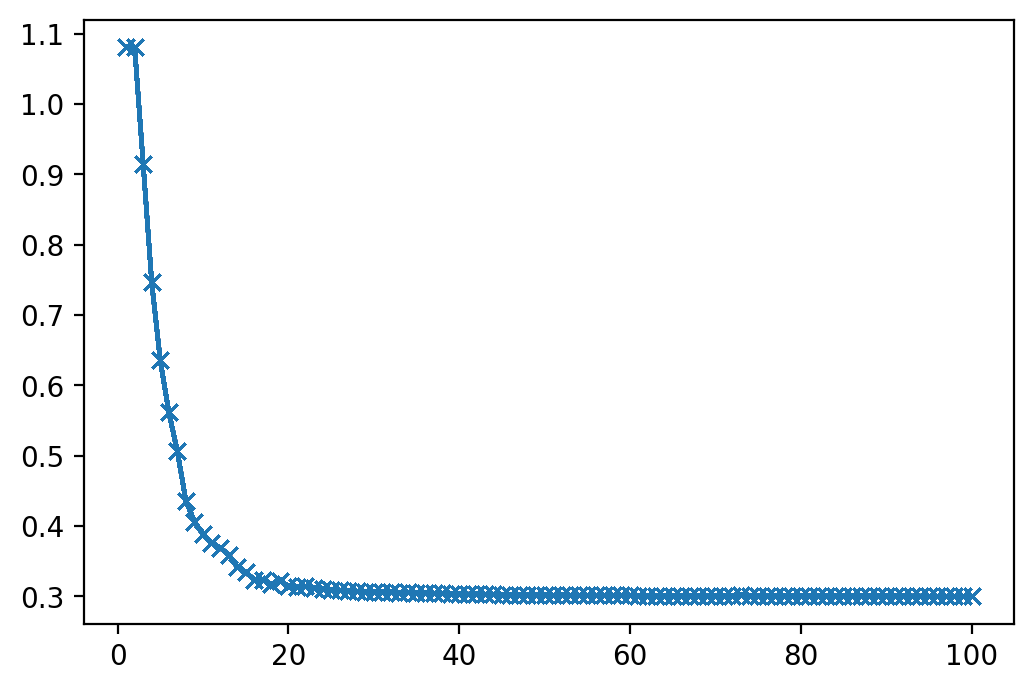

In [58]:
errors_mean = np.zeros(errors.shape)
coefficients_mean = np.zeros(coefficients.shape)
outputs_mean = np.zeros(outputs.shape)

assembles = 25
for i in range(assembles):
    results = perform_fit_ex2()
    errors_mean = errors_mean + results['errors']/assembles
    coefficients_mean = coefficients_mean + results['coefficients']/assembles
    outputs_mean = outputs_mean + results['outputs']/assembles

MSE_err_k = np.zeros(100)
for k in range(kmax):
    w2 = coefficients_mean[0, k]
    w1 = coefficients_mean[1, k]
    w = np.array([[w2], [w1]])
    MSE_err[k] = MSE(w, R, p)
    
    
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, 100, 100), MSE_err, color='#1f77b4', marker='x')
fig.savefig('lista2_2c2.pdf', bbox_inches = 'tight')

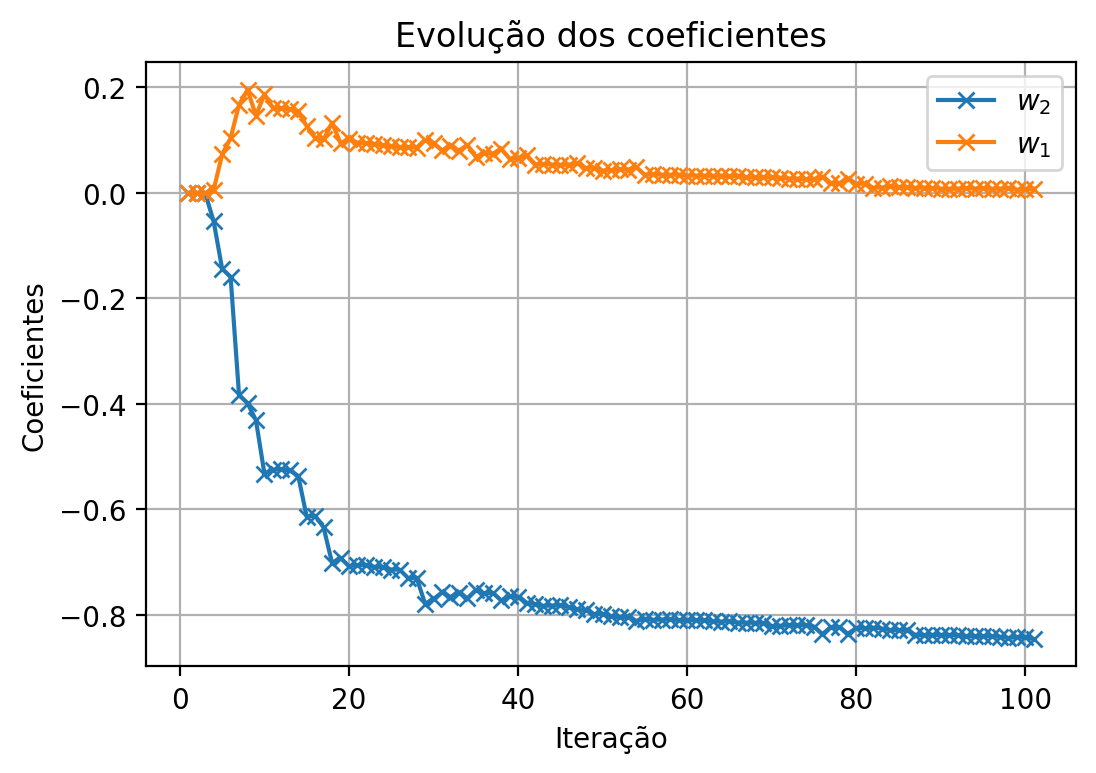

In [59]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, 101, 101), coefficients[0, :], color='#1f77b4', marker='x', label='$w_2$')
ax.plot(np.linspace(1, 101, 101), coefficients[1, :], color='#ff7f0e', marker='x', label='$w_1$')

ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolução dos coeficientes')
fig.savefig('lista2_2c4.pdf', bbox_inches = 'tight')

Observa-se curva mais suave ao se obter a média.

## Questão 9

### Item a

A entrada do filtro é dada pela equação

$x(k) = h(k) * n(k)$

Em que h(k) é a resposta ao ímpulso do filtro. Aplicando a transformada z na equação, obtêm-se

$X(z) = H(z) \cdot N(z)$

$X(z) = \dfrac{z}{z-0.9} \cdot N(z) = \dfrac{1}{1-0.9z^{-1}} \cdot N(z)$

$(1 - 0.9z^{-1})X(z) = N(z)$

Aplicando a inversa

$x(k) = 0.9x(k-1) + n(k)$

Novamente, o sistema está na forma

$x(k) = -a_1x(k-1) + n(k)$

Pelo exemplo 2.1, a correlação é dada por

$r(l) = \dfrac{(-a_1)^{|l|}}{1-a_1^2}\cdot \sigma_n^2 = \dfrac{(0.9)^{|l|}}{1-0.9^2}\cdot 0.5$

In [60]:
def r(l):
    return ((.9) ** abs(l))/(1-(.9) ** 2) * 0.5

Portanto, para o caso 2x2

In [61]:
R = np.array([[r(0), r(1)], [r(-1), r(0)]])
print(R)

[[2.63157895 2.36842105]
 [2.36842105 2.63157895]]


Considerando que o sinal desejado é da forma $d(k) = x(k+l)$, o vetor $\vec{p}$ será

$\vec{p} = E[d(k)\vec{x}(k)] = E[x(k+l)[x(k)\hspace{2mm} x(k-1)]^T] = [r(l)\hspace{2mm} r(l-1)]^T$

Portanto, para $l=1$

In [62]:
p = np.array([[r(1)], [r(2)]])
print(p)

[[2.36842105]
 [2.13157895]]


Portanto, a solução de Wiener será

$\vec{w_o} = R^{-1} \vec{p}$

In [63]:
wo = np.dot(LA.inv(R), p) 
print(wo)

[[0.9]
 [0. ]]


### Item b

Pela equação 3.30

$0 < \mu < \dfrac{1}{tr[R]}$

Portanto $\mu_{max}$ é 

In [64]:
mu_max = 1/np.trace(R)
print(mu_max)

0.18999999999999995


Assumindo $\mu = 0.1$

In [65]:
mu = .1

Configura-se o problema para 100 iterações

In [66]:
kmax = 100

def perform_fit_ex9():
    # Ruído Branco
    n_mean = 0
    n_var = 0.5
    n = np.random.normal(n_mean, np.sqrt(n_var), size=kmax)

    # wo
    wo = np.array([[.9], [0]])

    # Entrada
    def set_x(x0, kmax):
        x = np.array([x0])
        for k in range(1, kmax):
            x = np.append(x, [.9 * x[k-1] + n[k]])
        return x

    x = set_x(0, kmax)

    # Valor desejado
    def set_d(wo, x, kmax):
        d = np.array([0])
        for k in range(1, kmax):
            tapped_x = LMS.tapped_x(x, wo.shape[0], k)
            d = np.append(d, np.dot(tapped_x, wo))
        return d

    d = set_d(wo, x, kmax)

    # Filtro
    w0 = np.array([[0], [0]])
    adaptive_filter = LMS(1, w0)
    results = adaptive_filter.fit(d, x, mu)
    return results

results = perform_fit_ex9()
errors = results['errors']
coefficients = results['coefficients']
outputs = results['outputs']

O erro MSE é dado pela equação 2.90

$MSE = E[d^2(k)] - 2\vec{w}^T\vec{p} + \vec{w}^TR\vec{w}$

In [67]:
def MSE(w, R, p):
    return r(0) - 2 * np.dot(w.T, p) + np.dot(np.dot(w.T, R), w)

Portanto, o caminho de convergência será

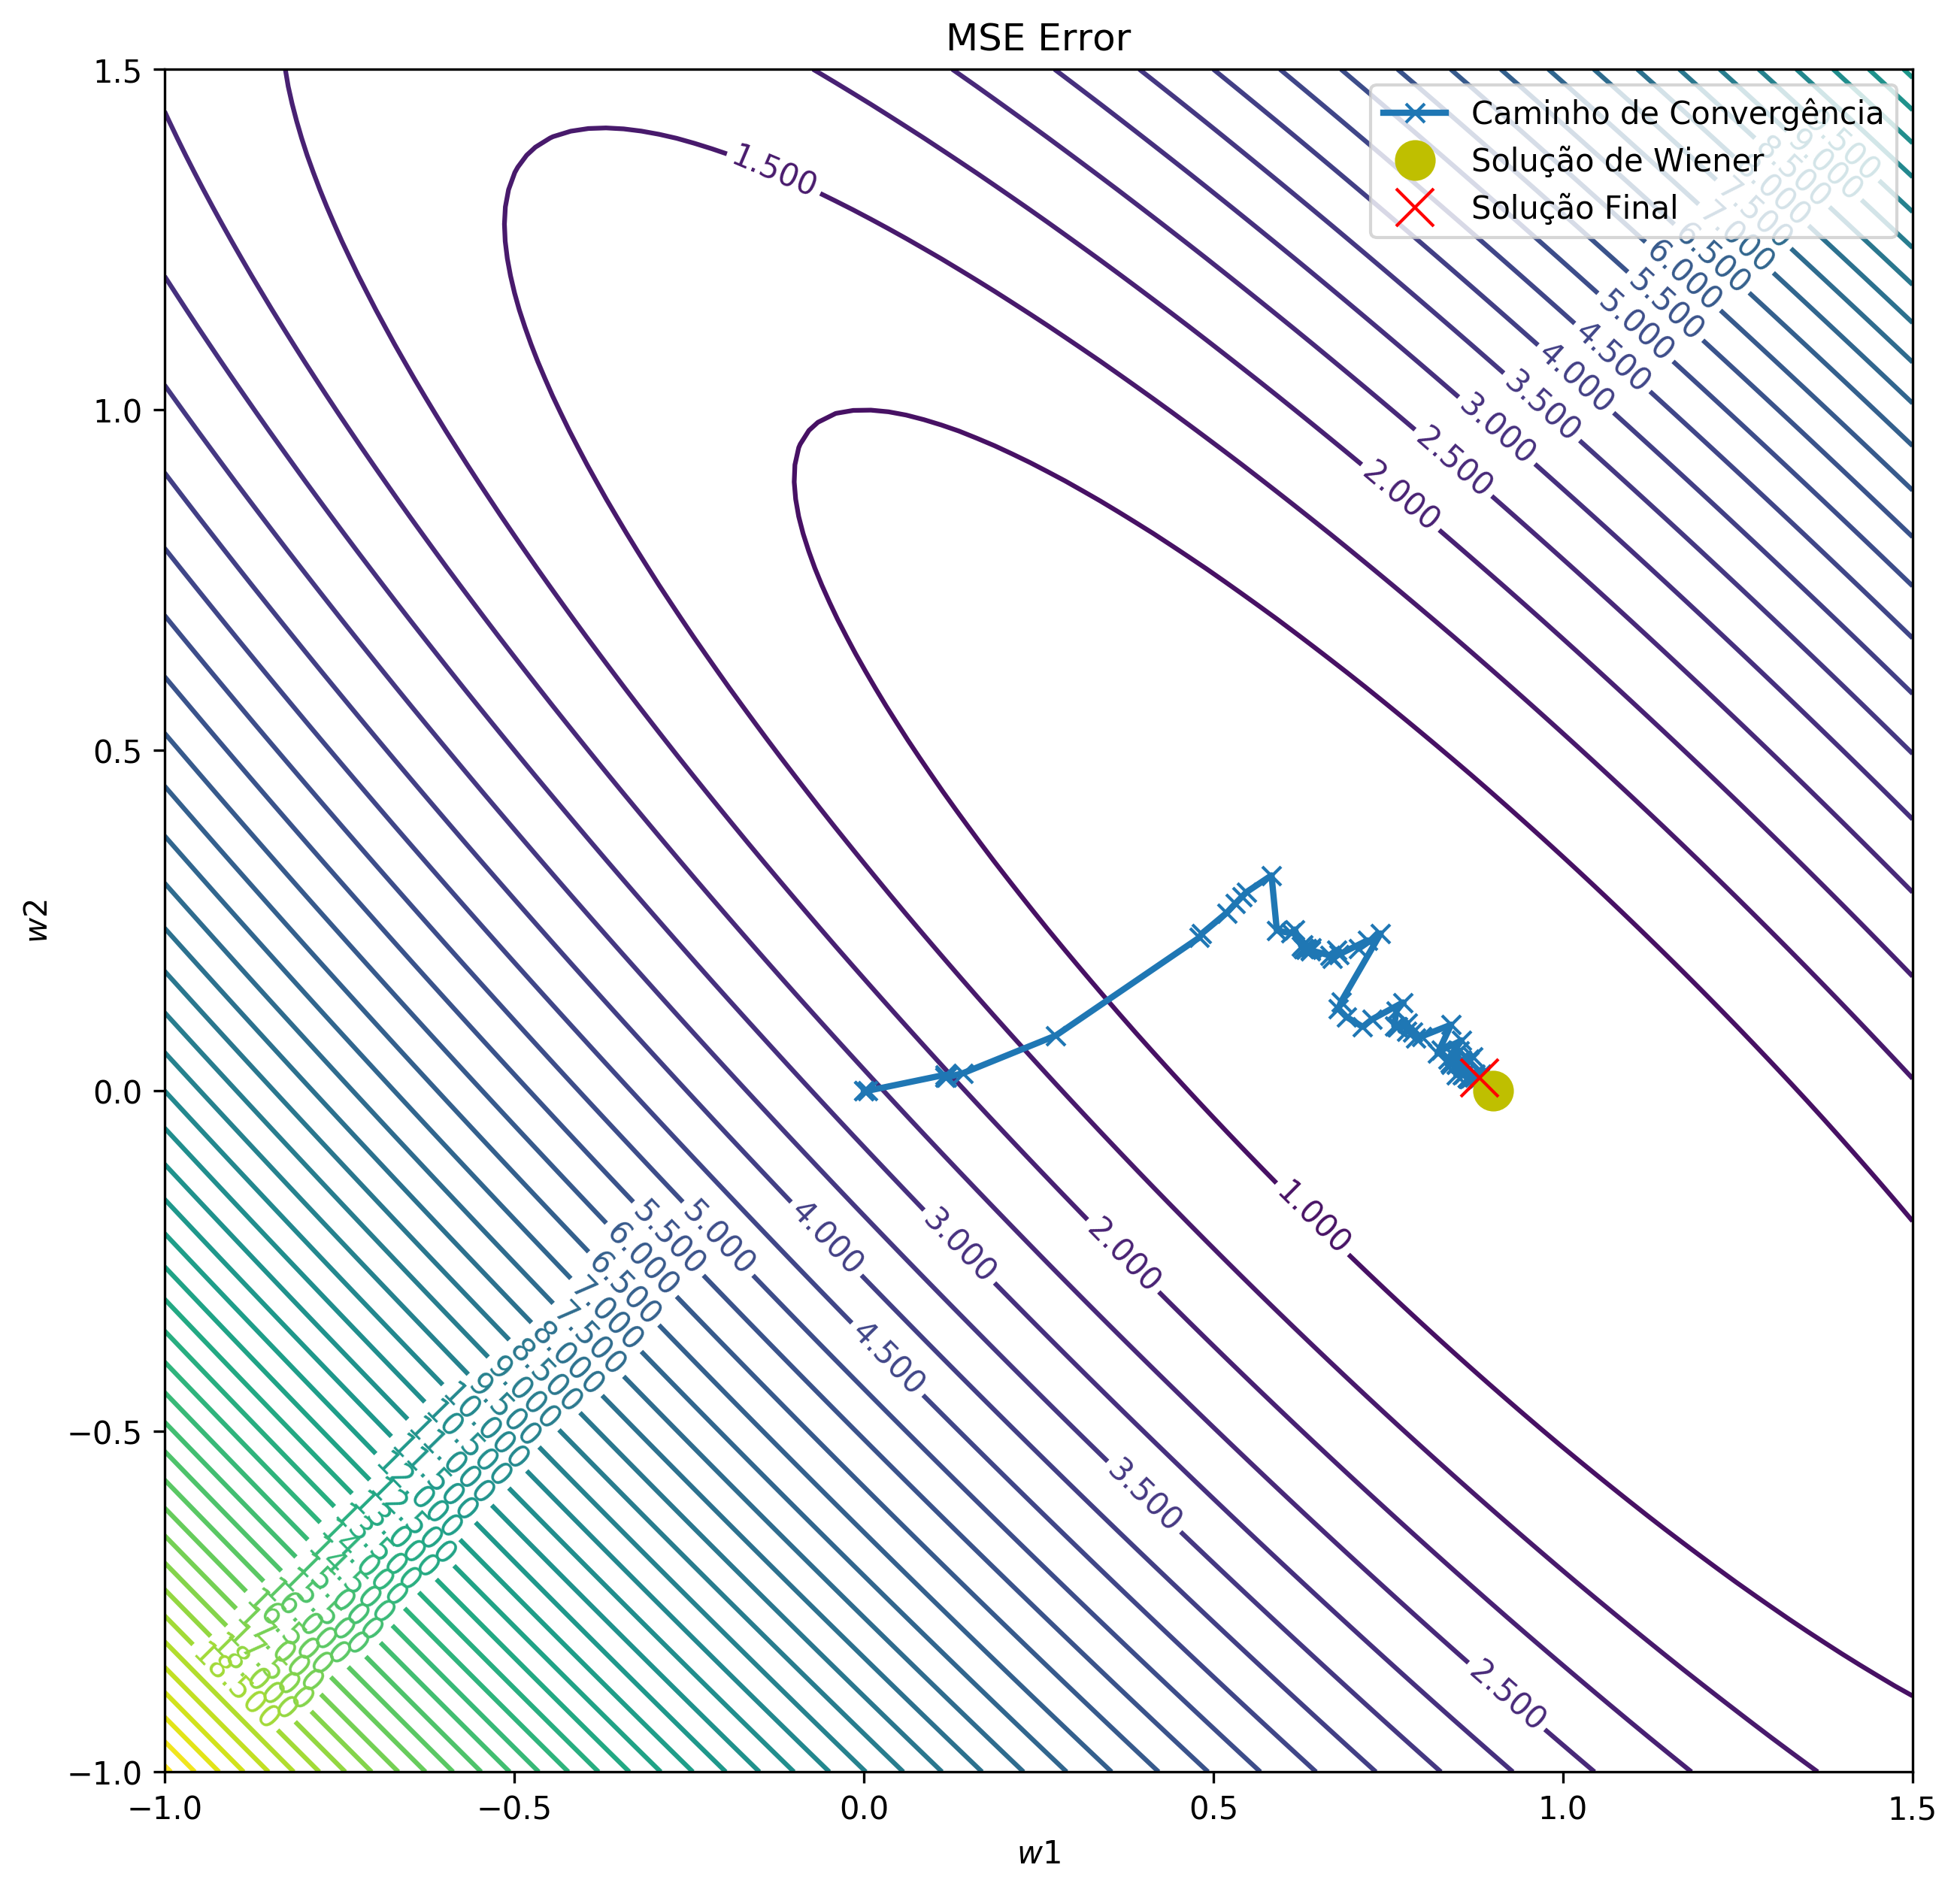

In [68]:
w1 = np.linspace(-1, 1.5, 100)
w2 = np.linspace(-1, 1.5, 100)

MSE_err = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        wj = w2[j]
        wi = w1[i]
        w = np.array([[wj], [wi]])
        MSE_err[i][j] = MSE(w, R, p)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10), dpi=300)        

# Curva de Nível
ct = ax.contour(w1, w2, MSE_err, levels=np.arange(0, np.max(MSE_err), 0.5))
ax.clabel(ct, ct.levels)

# Caminho dos coeficientes
ax.plot(coefficients[0, :], coefficients[1, :], '-x', label='Caminho de Convergência', linewidth=2, markersize=6)

# Wiener
ax.plot(wo[0], wo[1], 'o', color='y', markersize=12, label='Solução de Wiener')

# Solução final
ax.plot(coefficients[0, -1], coefficients[1, -1], 'x', label='Solução Final', color='r', markersize=12, linewidth=2)

ax.legend()
ax.set_xlabel('$w1$')
ax.set_ylabel('$w2$')
ax.set_title('MSE Error')
fig.savefig('lista2_9b.pdf', bbox_inches = 'tight')

### Item c

Usando o item b, plota-se a curva de aprendizado para uma realização

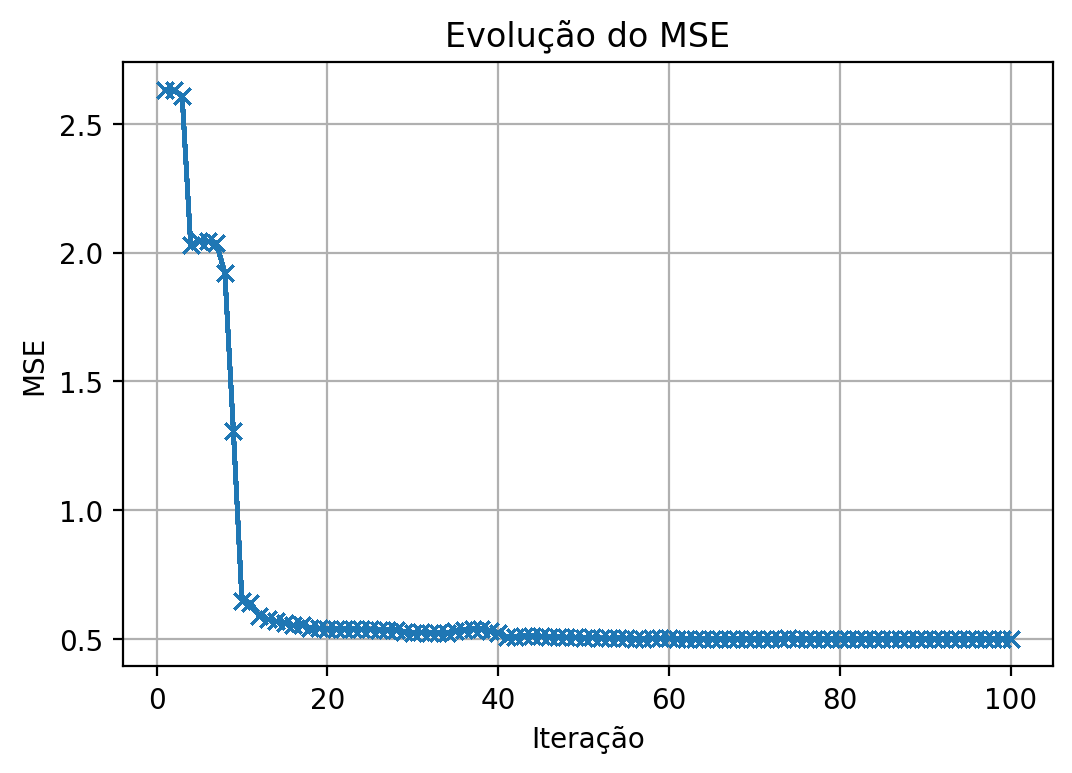

In [69]:
MSE_err_k = np.zeros(100)
for k in range(kmax):
    w2 = coefficients[0, k]
    w1 = coefficients[1, k]
    w = np.array([[w2], [w1]])
    MSE_err[k] = MSE(w, R, p)
    
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, 100, 100), MSE_err, color='#1f77b4', marker='x')

ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('MSE')
ax.set_title('Evolução do MSE')
fig.savefig('lista2_9c1.pdf', bbox_inches = 'tight')

A evolução dos coeficientes é

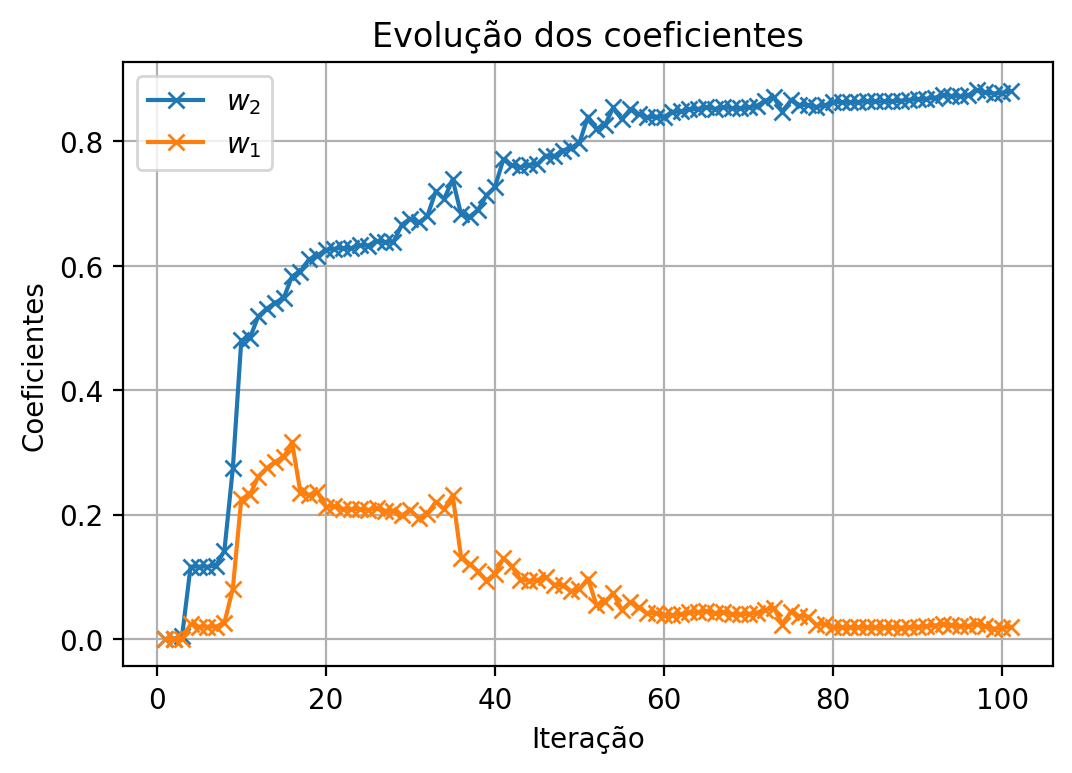

In [70]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, 101, 101), coefficients[0, :], color='#1f77b4', marker='x', label='$w_2$')
ax.plot(np.linspace(1, 101, 101), coefficients[1, :], color='#ff7f0e', marker='x', label='$w_1$')

ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolução dos coeficientes')
fig.savefig('lista2_9c3.pdf', bbox_inches = 'tight')


Para 25 realizações, obtendo a média

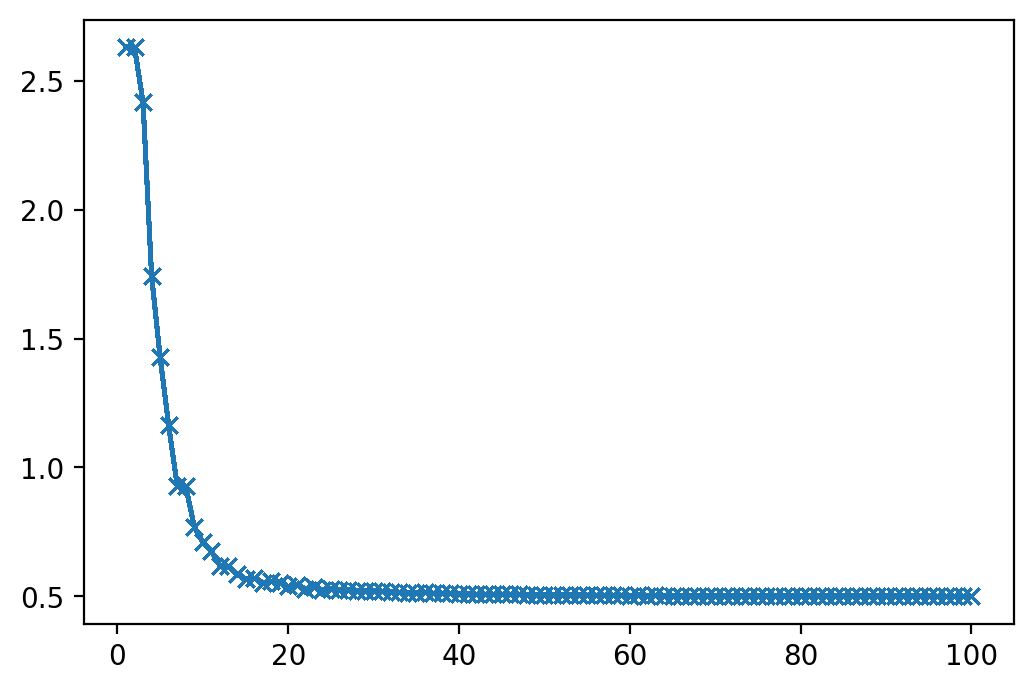

In [102]:
errors_mean = 0
coefficients_mean = 0
outputs_mean = 0

assembles = 25
for i in range(assembles):
    results = perform_fit_ex9()
    errors_mean = errors_mean + results['errors']/assembles
    coefficients_mean = coefficients_mean + results['coefficients']/assembles
    outputs_mean = outputs_mean + results['outputs']/assembles

MSE_err_k = np.zeros(100)
for k in range(kmax):
    w2 = coefficients_mean[0, k]
    w1 = coefficients_mean[1, k]
    w = np.array([[w2], [w1]])
    MSE_err[k] = MSE(w, R, p)
    
    
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, 100, 100), MSE_err, color='#1f77b4', marker='x')
fig.savefig('lista2_9c2.pdf', bbox_inches = 'tight')

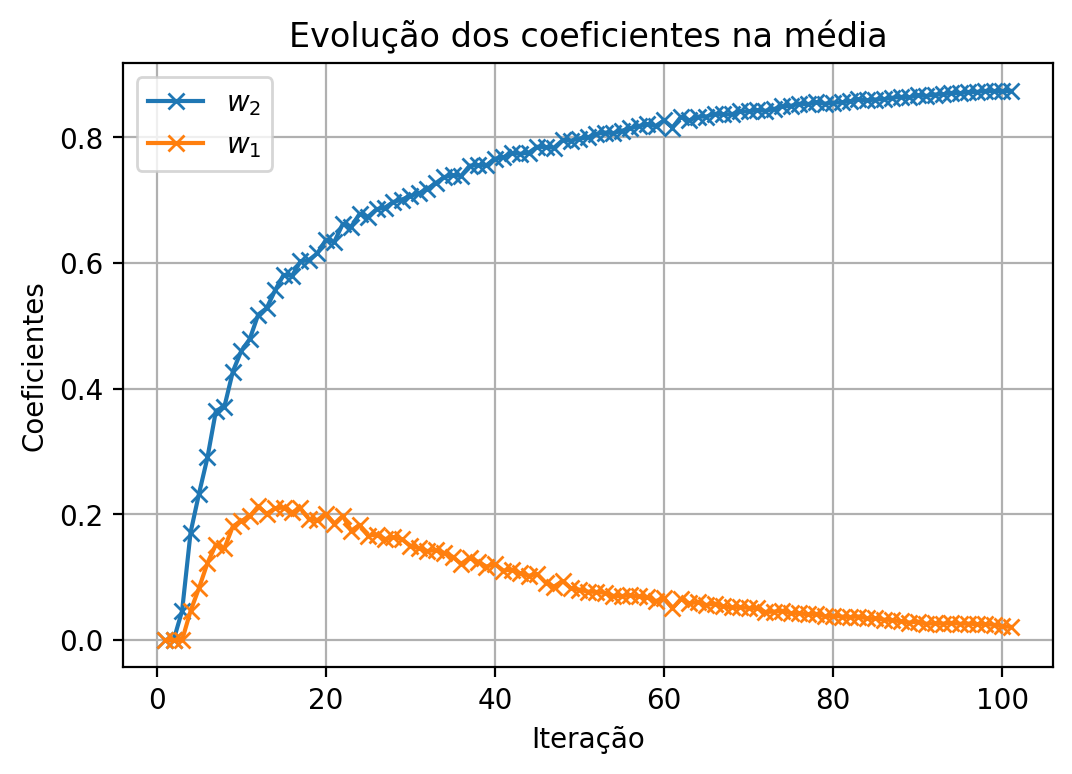

In [103]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, 101, 101), coefficients_mean[0, :], color='#1f77b4', marker='x', label='$w_2$')
ax.plot(np.linspace(1, 101, 101), coefficients_mean[1, :], color='#ff7f0e', marker='x', label='$w_1$')

ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolução dos coeficientes na média')
fig.savefig('lista2_9c4.pdf', bbox_inches = 'tight')

Novamente observa-se curva mais suave ao se obter a média.

## Questão 7

### Item a

O sinal de entrada é

$x(k) = n_1(k)$

Em que $n_1(k)$ é um ruído branco. Como a entrada é uma ruído branco, então, para o caso 12 x 12

$R = \sigma_x^2 I = I$

In [104]:
R = np.eye(12)
print(R)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Portanto, um limitante superior para $\mu$ é

$0 < \mu < \dfrac{1}{tr[R]}$

In [105]:
mu_max = 1/np.trace(R)
print(mu_max)

0.08333333333333333


### Item b

In [180]:
# Número de iterações
kmax = 2000

def get_inputs_ex7b(kmax):
    # Ruído de entrada
    mean_n1 = 0
    var_n1 = 1
    n1 = 3.5 * np.sqrt(var_n1) * (np.random.uniform(size=kmax) -.5)

    # Ruído de medição
    mean_n2 = 0
    var_n2 = 1e-3
    n2 = np.random.normal(mean_n2, np.sqrt(var_n2), size=kmax)
    
    return n1, n2

def mu_factor(mu_max, f):
    return mu_max/f

Para o problema, o sinal desejado será

$d(k) = d'(k) + n_2(k)$

Em que $d'(k)$ é a saída do filtro a ser estimado sem o ruído de medição

$d'(k) = h(k) * n_1(k)$

In [172]:
# Construindo d

def build_d_ex7b(n1, n2):
    # a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
    #                      - a[1]*y[n-1] - ... - a[N]*y[n-N]

    a = [1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    b = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

    #                     -1              -M
    #         b[0] + b[1]z  + ... + b[M] z
    # D(z) = -------------------------------- X(z)
    #                     -1              -N
    #         a[0] + a[1]z  + ... + a[N] z

    return signal.lfilter(b, a, n1) + n2

Iniciando treinamento com média de 20 realizações. Para $\mu=\mu_{max}/2$

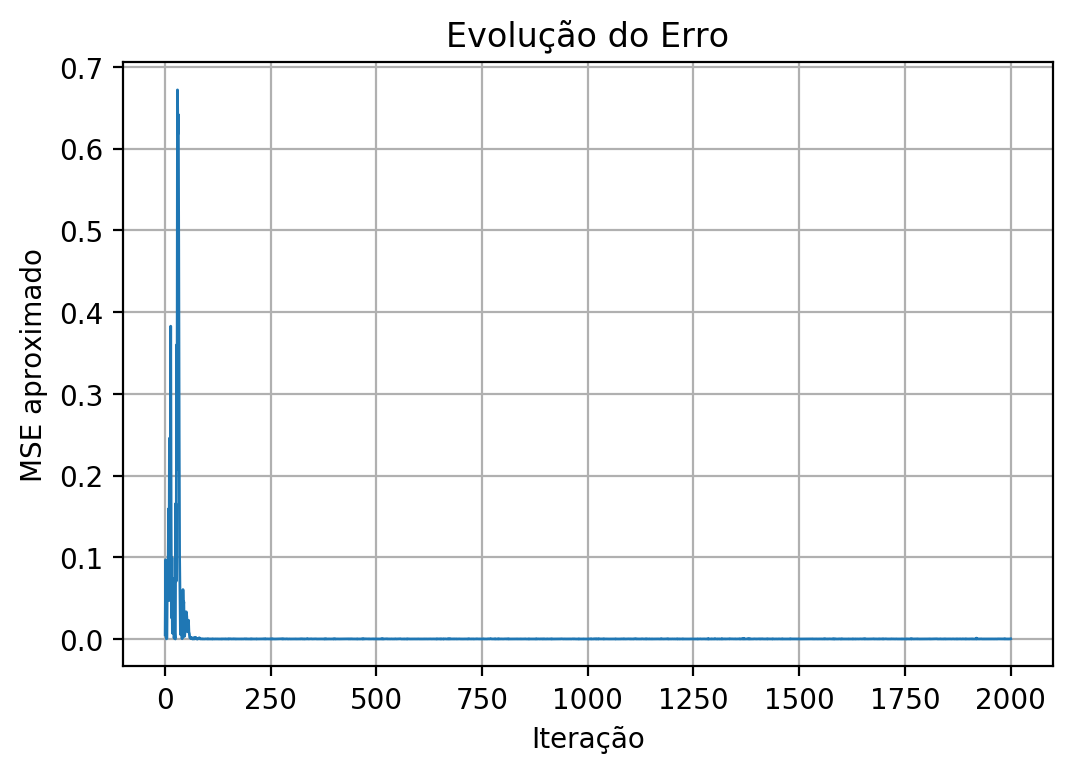

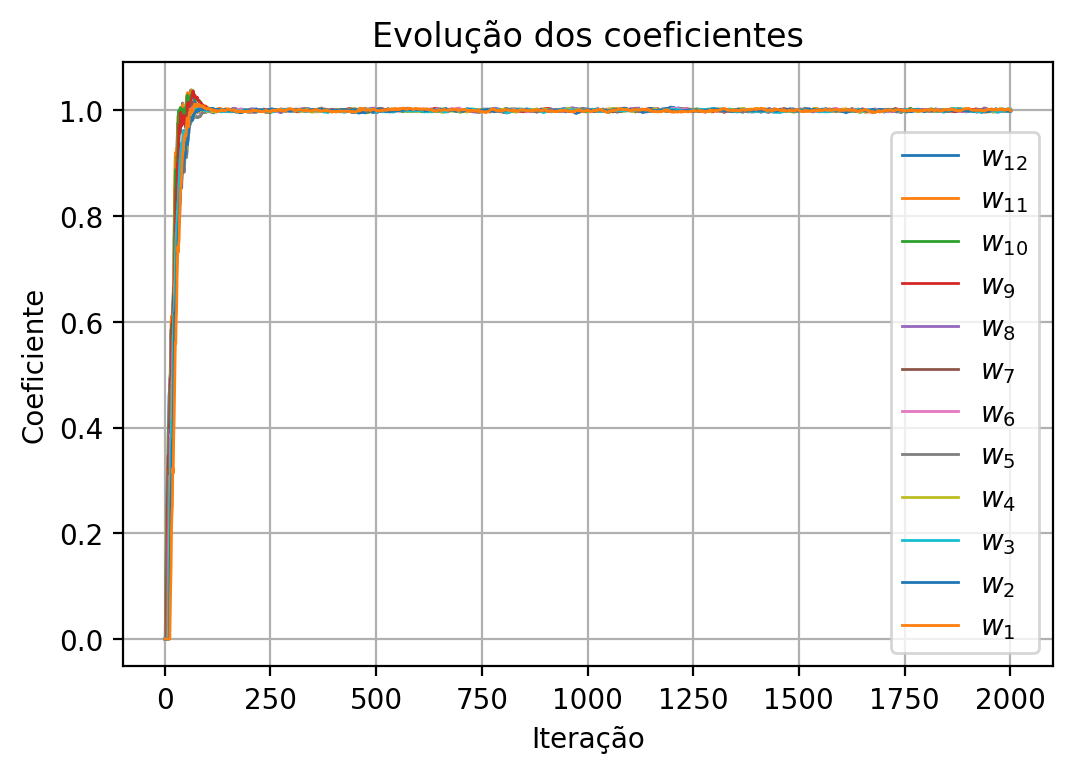

In [181]:
def perform_fit_ex7(mu, d, n1):
    w0 = np.array([[0], [0],[0], [0],[0], [0],[0], [0],[0], [0],[0],[0]])
    adaptive_filter = LMS(11, w0)
    results = adaptive_filter.fit(d, n1, mu)
    return results

errors_mean1 = 0
coefficients_mean1 = 0
outputs_mean1 = 0
mse_min_mean1 = 0

assembles = 25
for i in range(assembles):
    n1, n2 = get_inputs_ex7b(kmax)
    d = build_d_ex7b(n1, n2)
    results = perform_fit_ex7(mu_factor(mu_max, 2), d, n1)
    
    errors_mean1 = errors_mean1 + results['errors']/assembles
    coefficients_mean1 = coefficients_mean1 + results['coefficients']/assembles
    outputs_mean1 = outputs_mean1 + results['outputs']/assembles
    mse_min_mean1 = mse_min_mean1 + np.square(n2)/assembles
    
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, kmax, kmax), np.square(errors_mean1), color='#1f77b4', linewidth=1)
ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('MSE aproximado')
ax.set_title('Evolução do Erro')
fig.savefig('lista2_7b1.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
for i in range(12):
    index = 12 - i
    ax.plot(np.linspace(1, kmax+1, kmax+1), coefficients_mean1[i, :], linewidth=1, label='$w_{%i}$' % index)
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
ax.set_title('Evolução dos coeficientes')
fig.savefig('lista2_7b2.pdf', bbox_inches = 'tight')

Para $\mu = \mu_{max}/10$

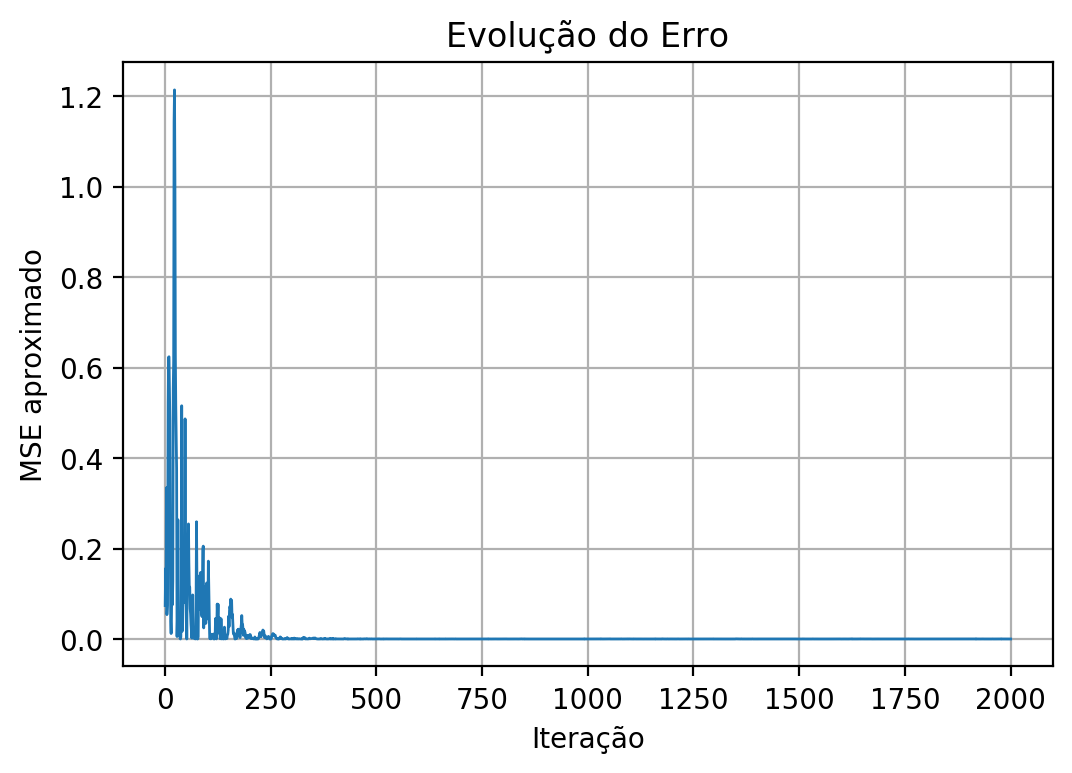

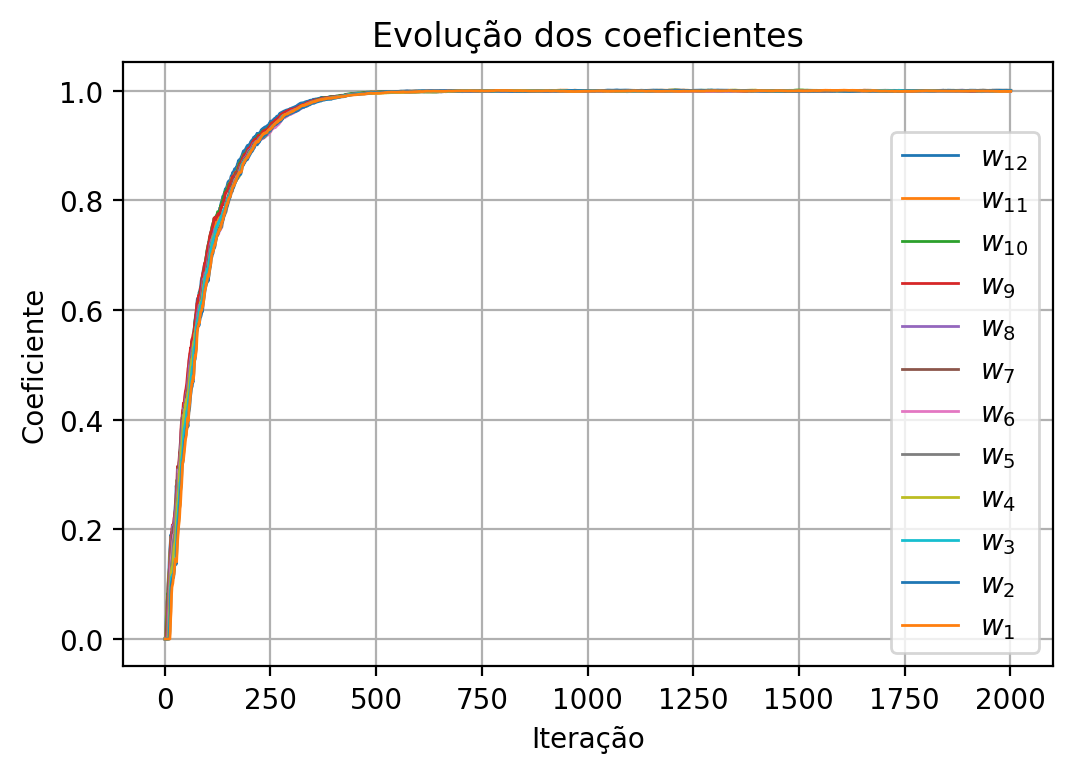

In [183]:
errors_mean2 = 0
coefficients_mean2 = 0
outputs_mean2 = 0
mse_min_mean2 = 0

assembles = 25
for i in range(assembles):
    n1, n2 = get_inputs_ex7b(kmax)
    d = build_d_ex7b(n1, n2)
    results = perform_fit_ex7(mu_factor(mu_max, 10), d, n1)
    
    errors_mean2 = errors_mean2 + results['errors']/assembles
    coefficients_mean2 = coefficients_mean2 + results['coefficients']/assembles
    outputs_mean2 = outputs_mean2 + results['outputs']/assembles
    mse_min_mean2 = mse_min_mean2 + np.square(n2)/assembles
    
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, kmax, kmax), np.square(errors_mean2), color='#1f77b4', linewidth=1)
ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('MSE aproximado')
ax.set_title('Evolução do Erro')
fig.savefig('lista2_7b3.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
for i in range(12):
    index = 12 - i
    ax.plot(np.linspace(1, kmax+1, kmax+1), coefficients_mean2[i, :], linewidth=1, label='$w_{%i}$' % index)
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
ax.set_title('Evolução dos coeficientes')
fig.savefig('lista2_7b4.pdf', bbox_inches = 'tight')

Para $\mu = \mu_{max}/50$

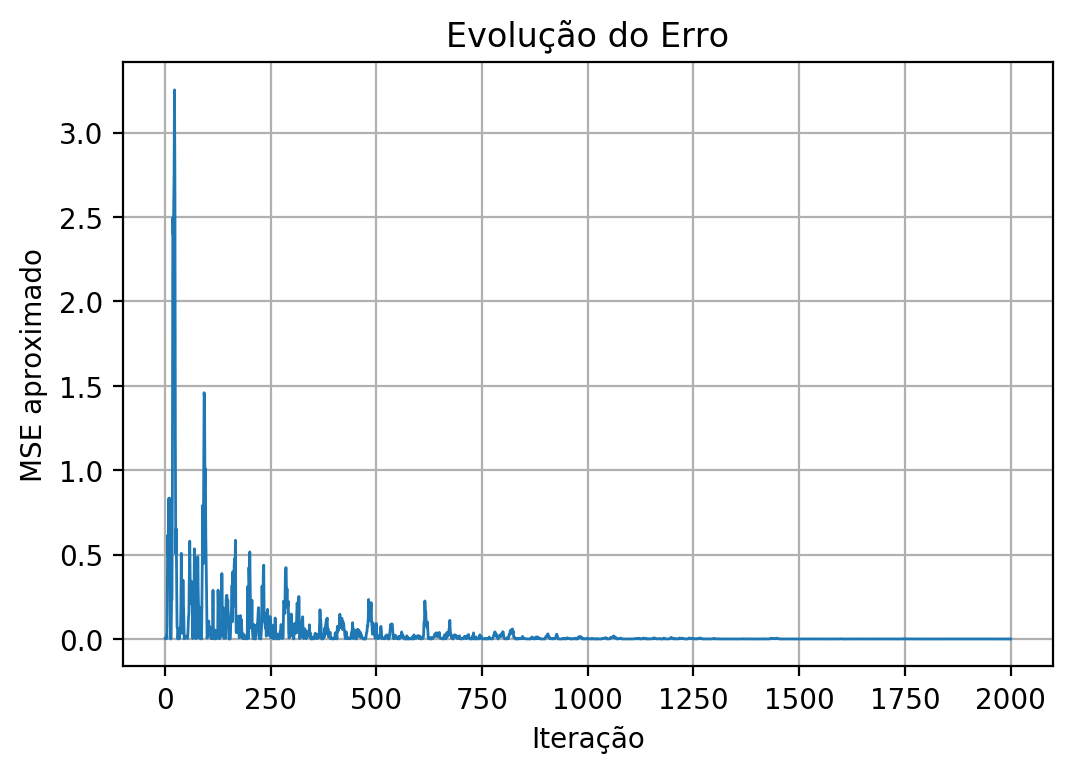

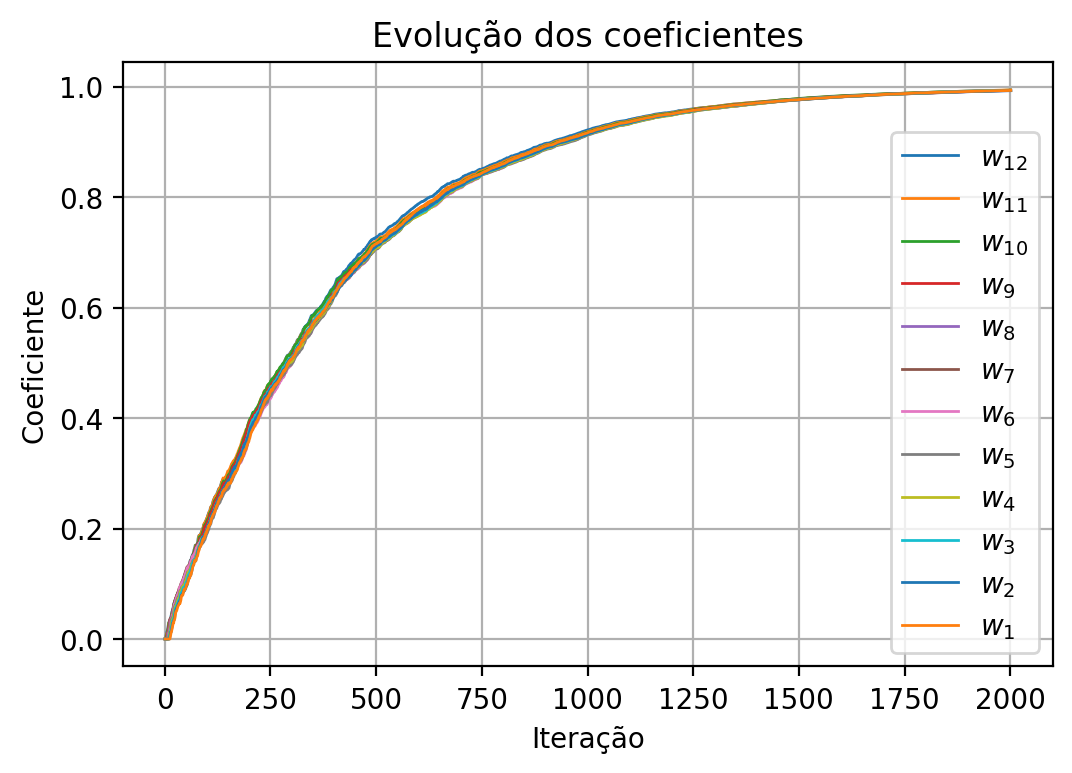

In [185]:
errors_mean3 = 0
coefficients_mean3 = 0
outputs_mean3 = 0
mse_min_mean3 = 0

assembles = 25
for i in range(assembles):
    n1, n2 = get_inputs_ex7b(kmax)
    d = build_d_ex7b(n1, n2)
    results = perform_fit_ex7(mu_factor(mu_max, 50), d, n1)
    
    errors_mean3 = errors_mean3 + results['errors']/assembles
    coefficients_mean3 = coefficients_mean3 + results['coefficients']/assembles
    outputs_mean3 = outputs_mean3 + results['outputs']/assembles
    mse_min_mean3 = mse_min_mean3 + np.square(n2)/assembles
    
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
ax.plot(np.linspace(1, kmax, kmax), np.square(errors_mean3), color='#1f77b4', linewidth=1)
ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('MSE aproximado')
ax.set_title('Evolução do Erro')
fig.savefig('lista2_7b5.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
for i in range(12):
    index = 12 - i
    ax.plot(np.linspace(1, kmax+1, kmax+1), coefficients_mean3[i, :], linewidth=1, label='$w_{%i}$' % index)
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
ax.set_title('Evolução dos coeficientes')
fig.savefig('lista2_7b6.pdf', bbox_inches = 'tight')

### Item c

Pela equação 3.50, o desajuste será

$$M = \frac{\xi_{exc}}{\xi_{min}}\approx \frac{\mu tr[R]}{1 - \mu tr[R]}$$

In [111]:
def m_theo(c_mu, R):
    return c_mu * np.trace(R)/(1 - c_mu * np.trace(R))

Para $\mu = \mu_{max}/2$

In [133]:
mu = mu_factor(2)
m_theo1 = m_theo(mu, R)
print("M teórico: ", m_theo1)

M teórico:  1.0


Para as últimas 100 iterações

In [134]:
m = np.zeros(errors_mean1.shape)
for k in range(kmax):
    m[k] = (errors_mean1[k] - mse_min_mean1[k])/mse_min_mean1[k]

m_mean = np.mean(m[-100:])
print("M Prático: ", m_mean)

M Prático:  -0.7814082581775265


Para $\mu = \mu_{max}/10$

In [135]:
mu = mu_factor(10)
m_theo2 = m_theo(mu, R)

m2 = np.zeros(errors_mean2.shape)
for k in range(kmax):
    m2[k] = (errors_mean2[k] - mse_min_mean2[k])/mse_min_mean2[k]

print("M teórico: ", m_theo2)

m_mean2 = np.mean(m2[-100:])
print("M Prático: ", m_mean2)

M teórico:  0.11111111111111112
M Prático:  -0.5706945688424292


Para $\mu = \mu_{max}/50$

In [136]:
mu = mu_factor(50)
m_theo3 = m_theo(mu, R)

m3 = np.zeros(errors_mean3.shape)
for k in range(kmax):
    m3[k] = (errors_mean3[k] - mse_min_mean3[k])/mse_min_mean3[k]

print("M teórico: ", m_theo3)

m_mean3 = np.mean(m3[-100:])
print("M Prático: ", m_mean3)

M teórico:  0.02040816326530612
M Prático:  -28.295019491442254


Observa-se que para $\mu$ muito pequeno, o M prático divergiu no M teórico.

### Item d

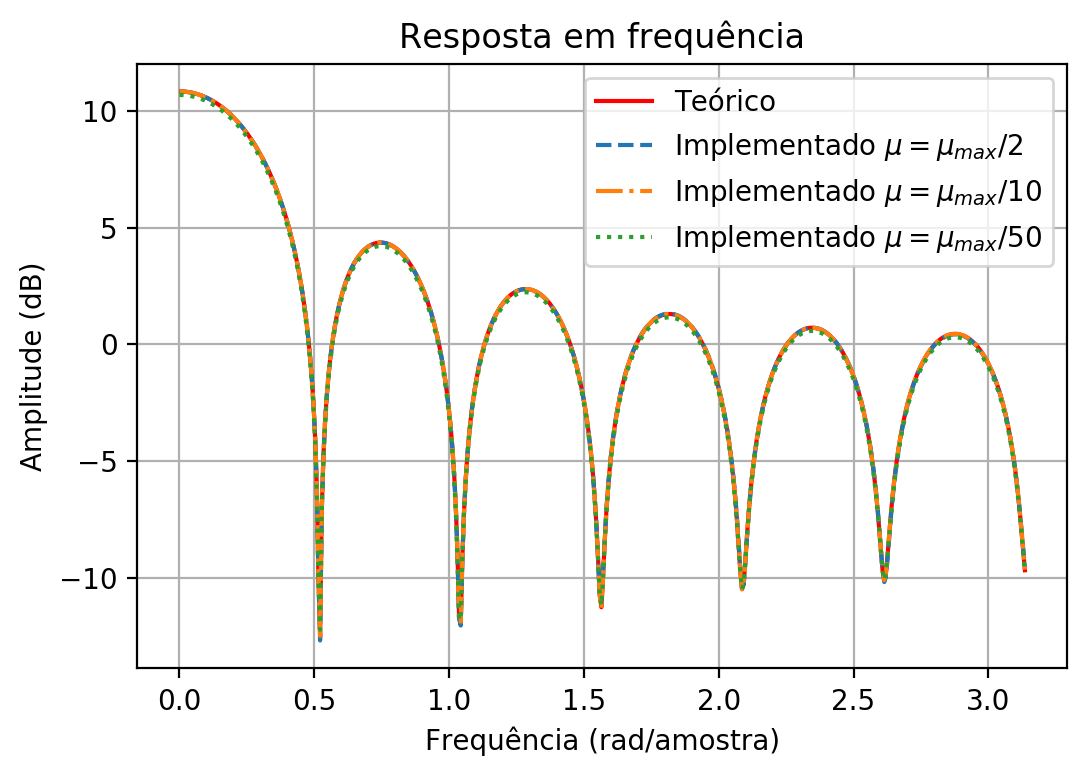

In [164]:
# Resposta em frequência do filtro de referência
a_ref = [1, -1]
b_ref = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

# wf_ref => Frequência
# h_ref => Resposta em frequência
wf_ref, h_ref = signal.freqz(b_ref, a=a_ref)

# Resposta para o filtro implementado
# mu = mu_max/2
wf_lms1, h_lms1 = signal.freqz(coefficients_mean1[:, -1])
# mu = mu_max/10
wf_lms2, h_lms2 = signal.freqz(coefficients_mean2[:, -1])
# mu = mu_max/50
wf_lms3, h_lms3 = signal.freqz(coefficients_mean3[:, -1])

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

ax.plot(wf_ref, 10 * np.log10(h_ref + 0.1), 'r', label='Teórico')
ax.plot(wf_lms1, 10 * np.log10(h_lms1 + 0.1), label='Implementado $\mu=\mu_{max}/2$', linestyle='--')
ax.plot(wf_lms2, 10 * np.log10(h_lms2 + 0.1), label='Implementado $\mu=\mu_{max}/10$', linestyle='-.')
ax.plot(wf_lms3, 10 * np.log10(h_lms3 + 0.1), label='Implementado $\mu=\mu_{max}/50$', linestyle=':')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Resposta em frequência')
ax.set_xlabel('Frequência (rad/amostra)')
ax.grid(True)
ax.legend()
fig.savefig('lista2_7d.pdf', bbox_inches = 'tight')
    

## Questão 8

### Item a

O sinal de entrada é

$x(k) = n_1(k)$

Em que $n_1(k)$ é um ruído branco. Como a entrada é uma ruído branco, então, para o caso 8 x 8

In [215]:
R = np.eye(8)
print(R)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Portanto, um limitante superior para $\mu$ é

$0 < \mu < \dfrac{1}{tr[R]}$

In [216]:
mu_max = 1/np.trace(R)
print(mu_max)

0.125


### Item b

Utilizando as mesmas funções usadas no ex. 7, obtêm-se, para o caso 8 x 8

Pela equação 3.37, por conta da nova ordem do filtro

$$\xi_{min} = \sum h^2 \cdot \sigma_x^2 + \sigma_n^2$$

Assim, define-se

In [282]:
def mse_min(w0, tapped_x, var_x, var_n):
    return (np.dot(tapped_x, w0) ** 2) * var_x

In [283]:
w0 = np.array([[0], [0],[0], [0],[0], [0],[0], [0]])

In [284]:
def perform_fit_ex8(mu, d, n1):
    adaptive_filter = LMS(7, w0)
    results = adaptive_filter.fit(d, n1, mu)
    return results

Treinando para $\mu=\mu_{max}/2$ e 25 realizações, obtêm-se

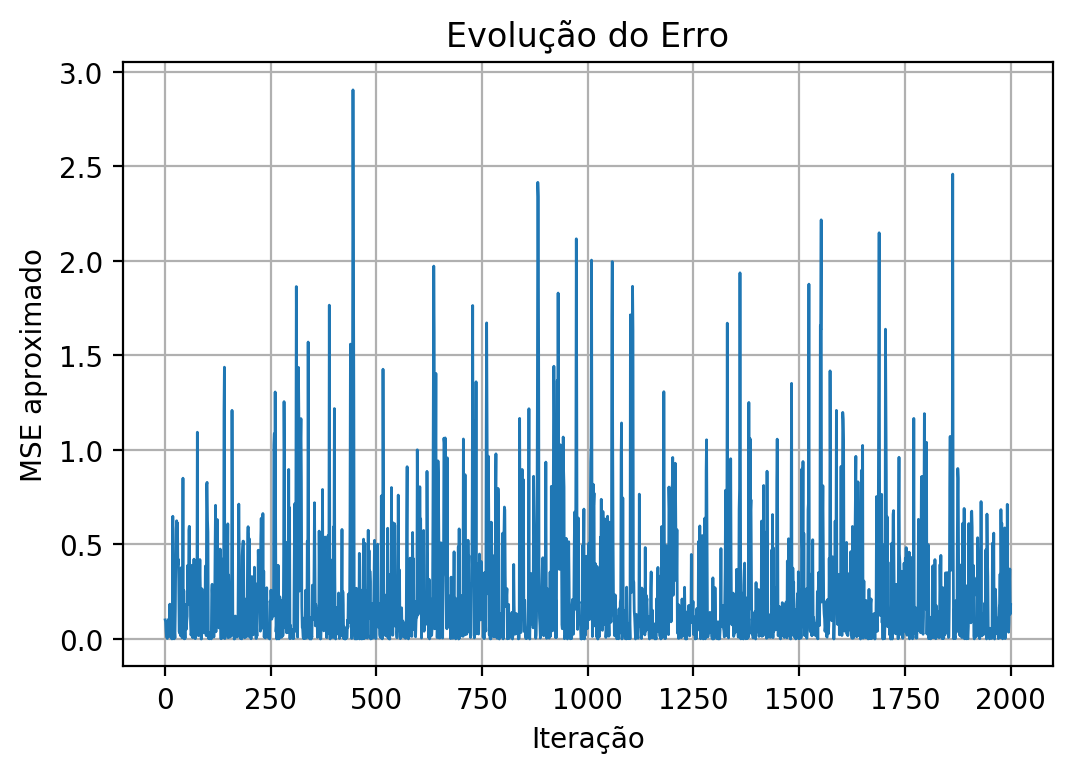

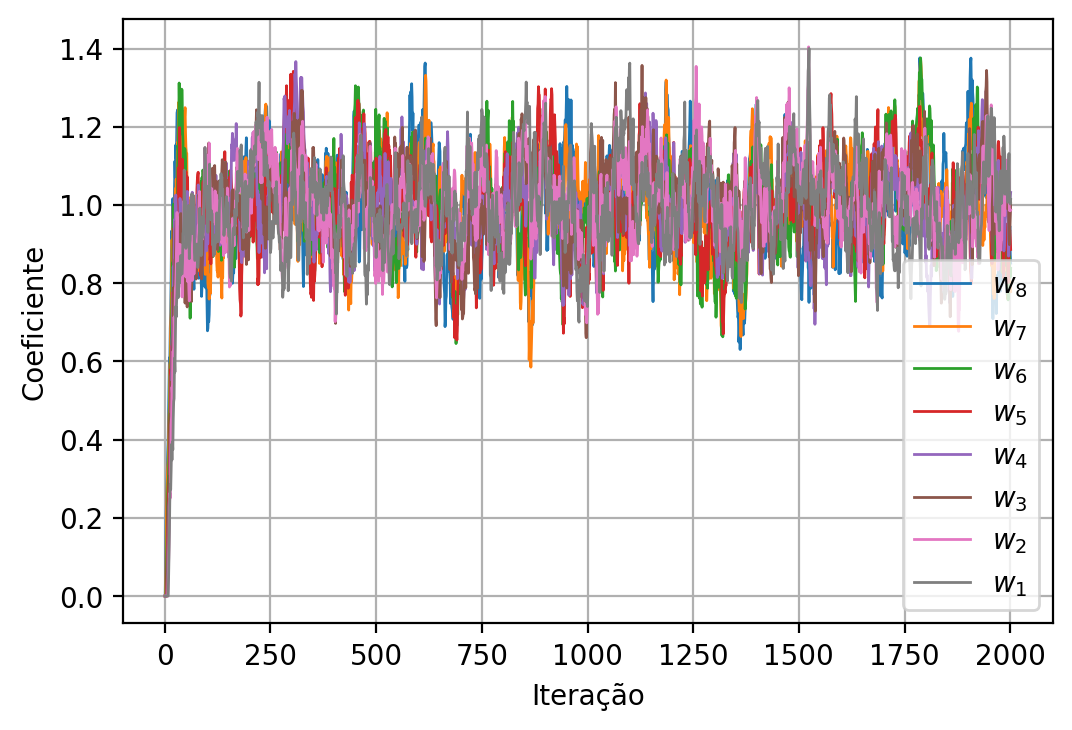

In [285]:
kmax = 2000

errors_mean1 = 0
coefficients_mean1 = 0
outputs_mean1 = 0
mse_min_mean1 = 0

assembles = 25
for i in range(assembles):
    n1, n2 = get_inputs_ex7b(kmax)
    d = build_d_ex7b(n1, n2)
    results = perform_fit_ex8(mu_factor(mu_max, 2), d, n1)
    
    errors_mean1 = errors_mean1 + results['errors']/assembles
    coefficients_mean1 = coefficients_mean1 + results['coefficients']/assembles
    outputs_mean1 = outputs_mean1 + results['outputs']/assembles
    
    wo = np.ones(12)
    mse_min1 = np.zeros(kmax) + var_n
    for k in range(kmax):
        mse_min1[k] = mse_min(wo, LMS.tapped_x(n1, 12, k), 1, 1e-3)
    
    mse_min_mean1 = mse_min_mean1 + mse_min1/assembles

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
ax.plot(np.linspace(1, kmax, kmax), np.square(errors_mean1), color='#1f77b4',linewidth=1)
ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('MSE aproximado')
ax.set_title('Evolução do Erro')
fig.savefig('lista2_8b1.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
for i in range(8):
    index = 8 - i
    ax.plot(np.linspace(1, kmax+1, kmax+1), coefficients_mean1[i, :],linewidth=1, label='$w_{%i}$' % index)
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
fig.savefig('lista2_8b2.pdf', bbox_inches = 'tight')

Treinando para $\mu=\mu_{max}/10$ e 25 realizações, obtêm-se

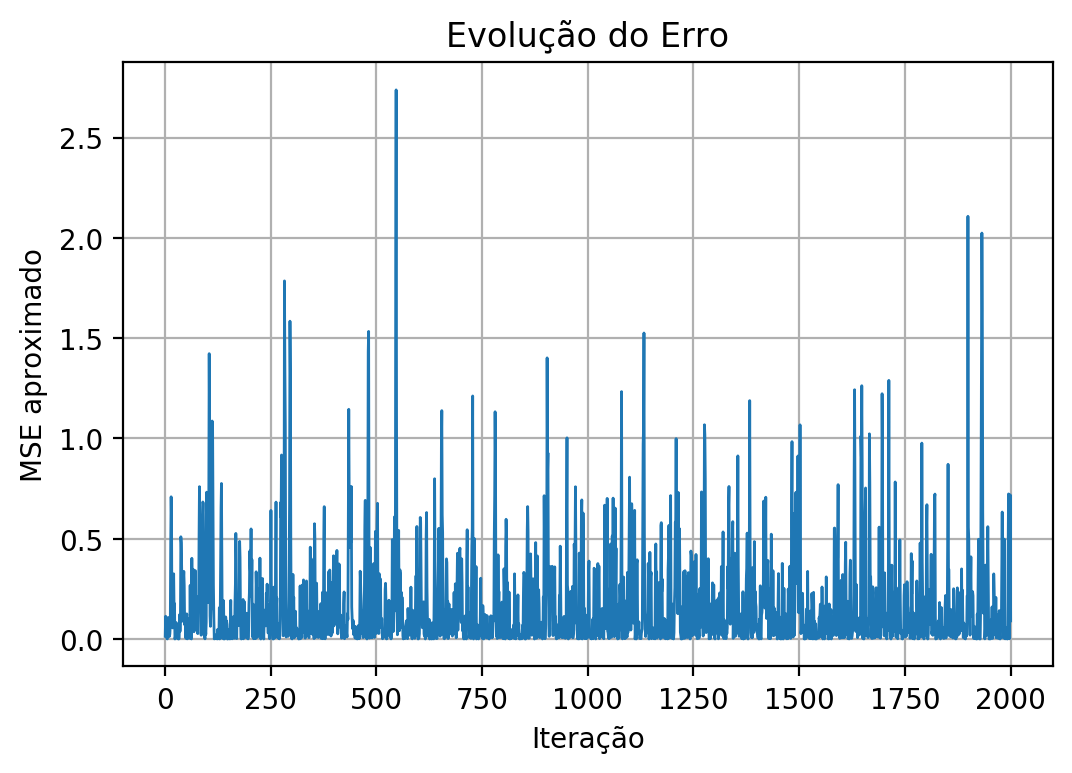

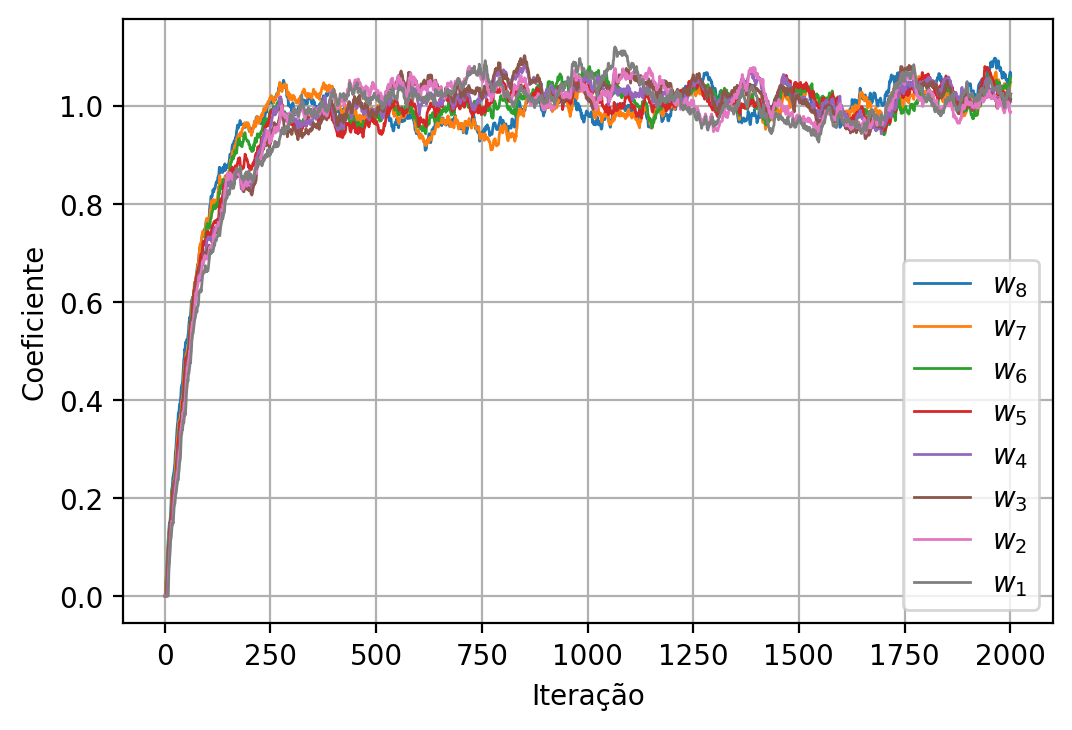

In [236]:
errors_mean2 = 0
coefficients_mean2 = 0
outputs_mean2 = 0
mse_min_mean2 = 0

assembles = 25
for i in range(assembles):
    n1, n2 = get_inputs_ex7b(kmax)
    d = build_d_ex7b(n1, n2)
    results = perform_fit_ex8(mu_factor(mu_max, 10), d, n1)
    
    errors_mean2 = errors_mean2 + results['errors']/assembles
    coefficients_mean2 = coefficients_mean2 + results['coefficients']/assembles
    outputs_mean2 = outputs_mean2 + results['outputs']/assembles
    mse_min_mean2 = mse_min_mean2 + np.square(n2)/assembles
    
    wo = np.ones(12)
    mse_min2 = np.zeros(kmax) + var_n
    for k in range(kmax):
        mse_min2[k] = mse_min(wo, LMS.tapped_x(n1, 12, k), 1, 1e-3)
    
    mse_min_mean2 = mse_min_mean2 + mse_min2/assembles

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
ax.plot(np.linspace(1, kmax, kmax), np.square(errors_mean2), color='#1f77b4',linewidth=1)
ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('MSE aproximado')
ax.set_title('Evolução do Erro')
fig.savefig('lista2_8b3.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
for i in range(8):
    index = 8 - i
    ax.plot(np.linspace(1, kmax+1, kmax+1), coefficients_mean2[i, :],linewidth=1, label='$w_{%i}$' % index)
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
fig.savefig('lista2_8b4.pdf', bbox_inches = 'tight')

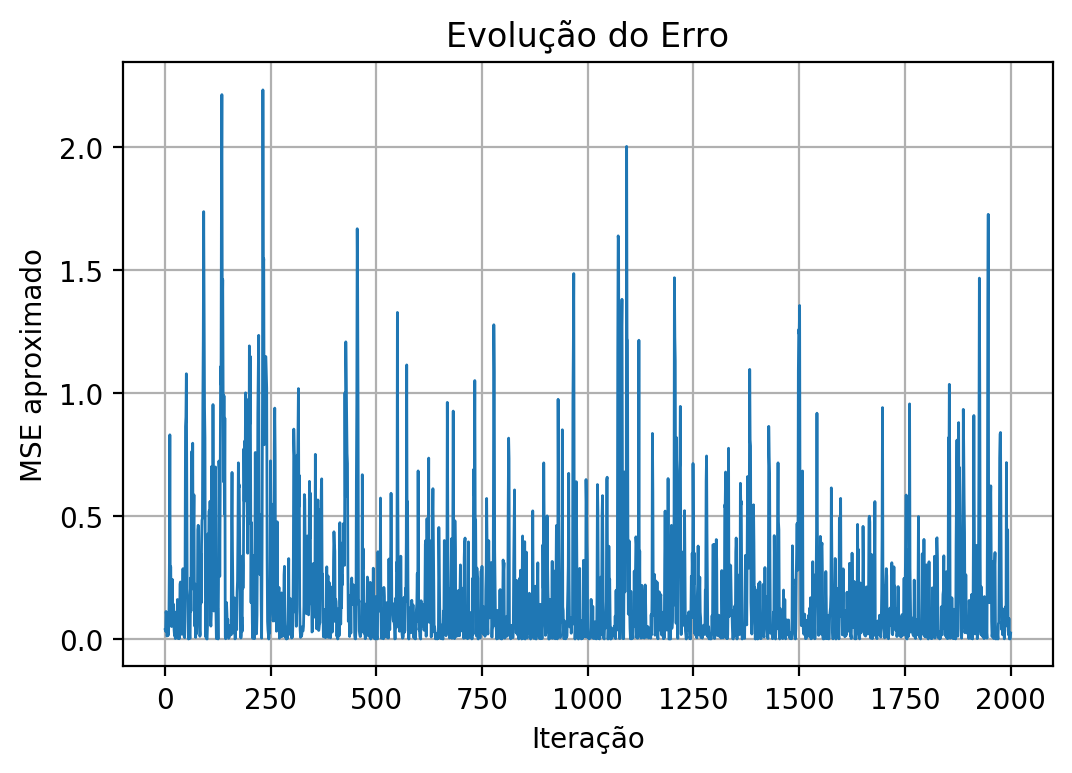

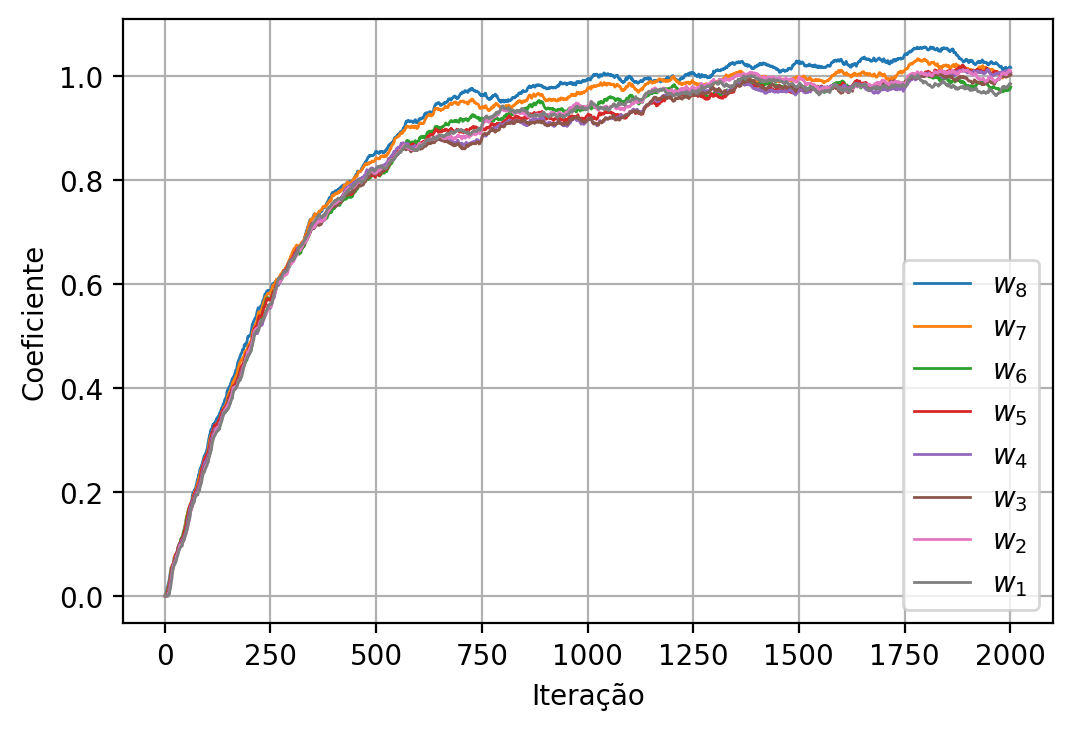

In [286]:
errors_mean3 = 0
coefficients_mean3 = 0
outputs_mean3 = 0
mse_min_mean3 = 0

assembles = 25
for i in range(assembles):
    n1, n2 = get_inputs_ex7b(kmax)
    d = build_d_ex7b(n1, n2)
    results = perform_fit_ex8(mu_factor(mu_max, 50), d, n1)
    
    errors_mean3 = errors_mean3 + results['errors']/assembles
    coefficients_mean3 = coefficients_mean3 + results['coefficients']/assembles
    outputs_mean3 = outputs_mean3 + results['outputs']/assembles
    mse_min_mean3 = mse_min_mean3 + np.square(n2)/assembles
    
    wo = np.ones(12)
    mse_min3 = np.zeros(kmax) + var_n
    for k in range(kmax):
        mse_min3[k] = mse_min(wo, LMS.tapped_x(n1, 12, k), 1, 1e-3)
    
    mse_min_mean3 = mse_min_mean3 + mse_min_it/assembles

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
ax.plot(np.linspace(1, kmax, kmax), np.square(errors_mean3), color='#1f77b4',linewidth=1)
ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('MSE aproximado')
ax.set_title('Evolução do Erro')
fig.savefig('lista2_8b5.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
for i in range(8):
    index = 8 - i
    ax.plot(np.linspace(1, kmax+1, kmax+1), coefficients_mean3[i, :],linewidth=1, label='$w_{%i}$' % index)
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
fig.savefig('lista2_8b6.pdf', bbox_inches = 'tight')

Observa-se erro quadrático pouco conclusívo e maior ruído nos coeficientes.

### Item c

Pela equação 3.50, o desajuste será

$$M = \frac{\xi_{exc}}{\xi_{min}}\approx \frac{\mu tr[R]}{1 - \mu tr[R]}$$

In [221]:
def m_theo(c_mu, R):
    return c_mu * np.trace(R)/(1 - c_mu * np.trace(R))

Para $\mu = \mu_{max}/2$

In [231]:
mu = mu_factor(mu_max, 2)
m_theo1 = m_theo(mu, R)
print("M teórico: ", m_theo1)

M teórico:  1.0


Para as últimas 100 iterações

In [238]:
m = np.zeros(errors_mean1.shape)
for k in range(kmax):
    m[k] = (errors_mean1[k] - mse_min_mean1[k])/mse_min_mean1[k]

m_mean = np.mean(m[-100:])
print("M Prático: ", m_mean)

M Prático:  -0.9843719525725725


Para $\mu = \mu_{max}/10$

In [240]:
mu = mu_factor(mu_max, 10)
m_theo2 = m_theo(mu, R)

m2 = np.zeros(errors_mean2.shape)
for k in range(kmax):
    m2[k] = (errors_mean2[k] - mse_min_mean2[k])/mse_min_mean2[k]

print("M teórico: ", m_theo2)

m_mean2 = np.mean(m2[-100:])
print("M Prático: ", m_mean2)

M teórico:  0.11111111111111112
M Prático:  -0.9941982788778264


Para $\mu = \mu_{max}/50$

In [241]:
mu = mu_factor(mu_max, 50)
m_theo3 = m_theo(mu, R)

m3 = np.zeros(errors_mean3.shape)
for k in range(kmax):
    m3[k] = (errors_mean3[k] - mse_min_mean3[k])/mse_min_mean3[k]

print("M teórico: ", m_theo3)

m_mean3 = np.mean(m3[-100:])
print("M Prático: ", m_mean3)

M teórico:  0.020408163265306124
M Prático:  -1.0106142328804402


Observa-se M prático próximo de -1.

### Item d

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:470: RuntimeWarning: invalid value encountered in true_divide
  npp_polyval(zm1, a, tensor=False))
/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


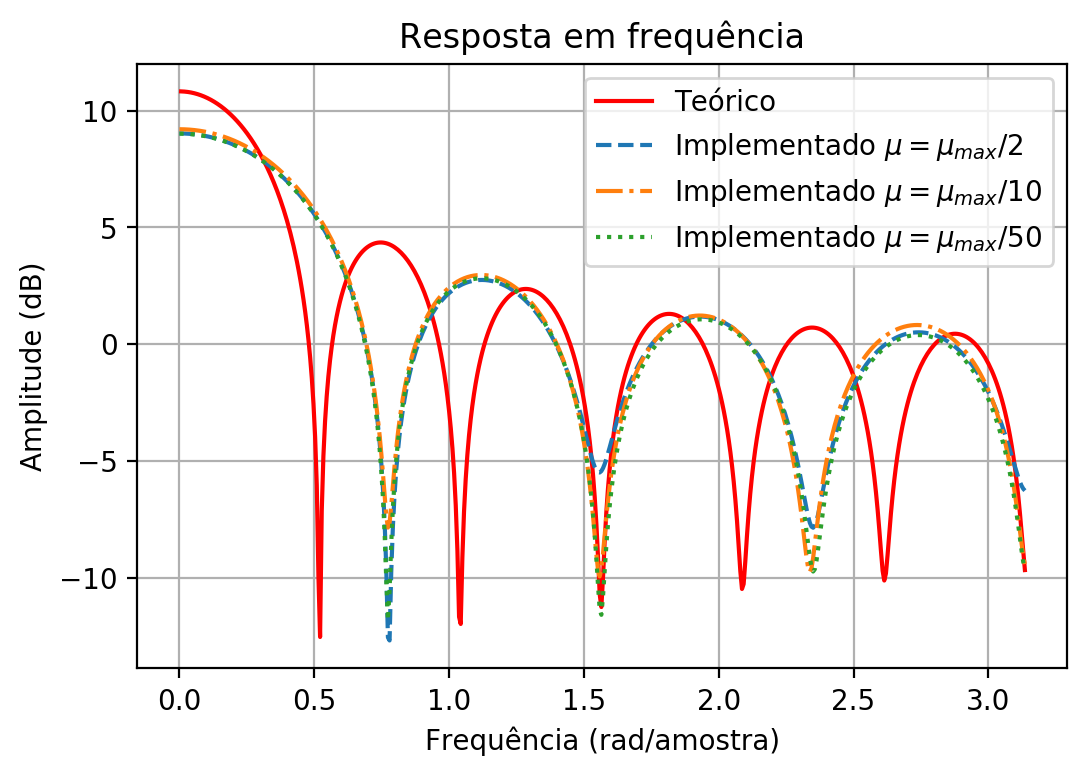

In [242]:
# Resposta em frequência do filtro de referência
a_ref = [1, -1]
b_ref = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

# wf_ref => Frequência
# h_ref => Resposta em frequência
wf_ref, h_ref = signal.freqz(b_ref, a=a_ref)

# Resposta para o filtro implementado
# mu = mu_max/2
wf_lms1, h_lms1 = signal.freqz(coefficients_mean1[:, -1])
# mu = mu_max/10
wf_lms2, h_lms2 = signal.freqz(coefficients_mean2[:, -1])
# mu = mu_max/50
wf_lms3, h_lms3 = signal.freqz(coefficients_mean3[:, -1])

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

ax.plot(wf_ref, 10 * np.log10(h_ref + 0.1), 'r', label='Teórico')
ax.plot(wf_lms1, 10 * np.log10(h_lms1 + 0.1), label='Implementado $\mu=\mu_{max}/2$', linestyle='--')
ax.plot(wf_lms2, 10 * np.log10(h_lms2 + 0.1), label='Implementado $\mu=\mu_{max}/10$', linestyle='-.')
ax.plot(wf_lms3, 10 * np.log10(h_lms3 + 0.1), label='Implementado $\mu=\mu_{max}/50$', linestyle=':')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Resposta em frequência')
ax.set_xlabel('Frequência (rad/amostra)')
ax.grid(True)
ax.legend()
fig.savefig('lista2_8d.pdf', bbox_inches = 'tight')

Observa-se deslocamento e diferença no número de picos por conta da diferença de ordem entre os filtros

## Questão 15

### Item a

Pela equação 3.75, como $\mu = 0.05$

$$\xi_{exc} = \mu \cdot \sigma_x^2 \cdot tr[R] + \frac{\sigma_w^2}{4\mu}(N+1)$$

Como a entrada é ruído gaussiano, então

$$R = \sigma_x^2 I$$

In [247]:
mu = 0.05
var_x = 0.7
var_n = 0.01
var_w = 0.001
N = 7

R = var_x * np.eye(N+1)
xi_exc = mu * var_n * np.trace(R) + var_w * (N + 1)/(4*mu)
print('Excesso de erro: ', xi_exc)

Excesso de erro:  0.0428


### Item b

Para $\mu = 0.01$

In [249]:
mu = 0.01
xi_exc = mu * var_n * np.trace(R) + var_w * (N + 1)/(4*mu)
print('Excesso de erro: ', xi_exc)

Excesso de erro:  0.20056000000000002


### Item c

Pela equação 3.76

$$\mu_{opt} = \sqrt{\frac{(N+1)\cdot \sigma_w^2}{4\sigma_n^2 \cdot tr[R]}}$$

In [251]:
mu_opt = np.sqrt((N+1)*var_w/(4*var_n*np.trace(R)))
print('mu ótimo: ', mu_opt)

mu ótimo:  0.18898223650461363


O valor máximo de $\mu$ é dado por

$$0 < \mu < \frac{1}{tr[R]}$$

In [252]:
mu_max = 1/np.trace(R)
print('mu máximo: ', mu_max)

mu máximo:  0.17857142857142858


Como $\mu_{max} < \mu_{opt}$, então o segundo não é factível.

## Questão 16

Como o processo é Markov de primeira ordem, os coeficientes ótimos são dados pela equação 3.65

$$\vec{w_o}(k) = \lambda_w\vec{w_o}(k-1) + n_w(k)$$

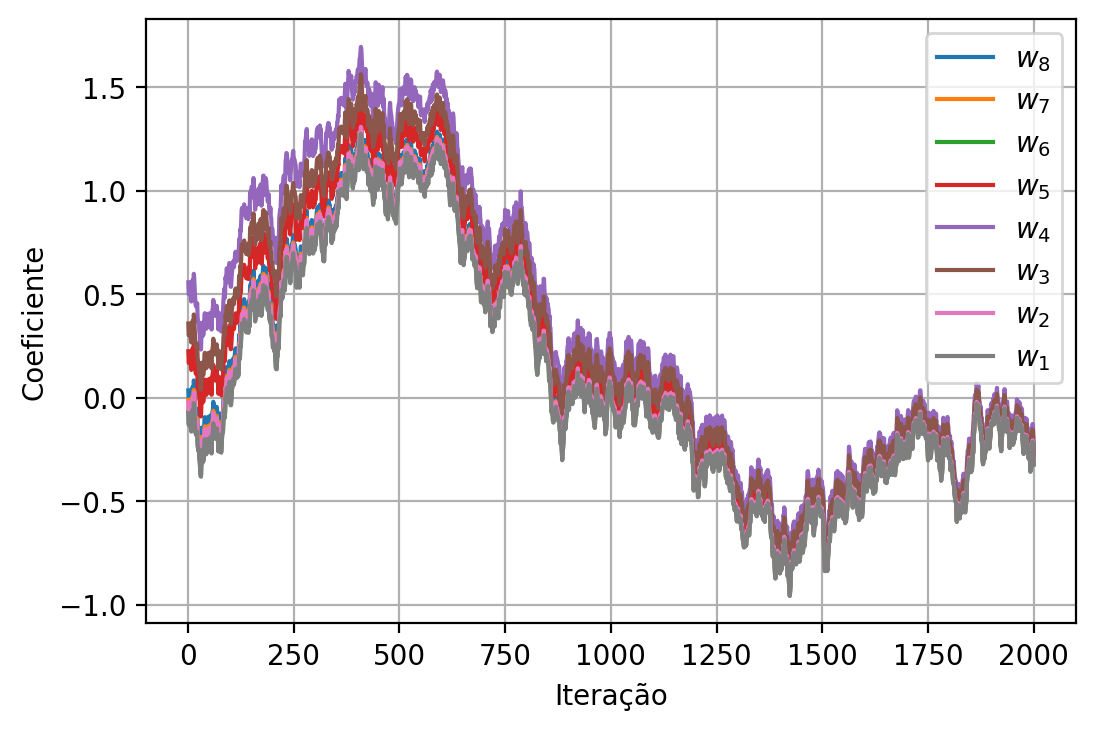

In [338]:
def wo_k(last_wo, lambda_w, n_k):
    return lambda_w * last_wo + n_k

kmax = 2000

# Ruído branco associado aos coeficientes ótimos
def generate_noise(nw_mean, nw_var, kmax):
    return np.random.normal(nw_mean, np.sqrt(nw_var), size=kmax)

nw_mean = 0
nw_var = 0.001
nw = generate_noise(nw_mean, nw_var, kmax)

# valor inicial de wo
wo_0 = np.array([[0.03490], [-0.011], [-0.06864], [0.22391], [0.55686], [0.35798], [-0.0239], [-0.07594]])

# Construíndo wo
def build_wo(wo_0, nw, kmax):
    number_of_coefficients = wo_0.shape[0]
    
    # prealocate 
    wo = np.zeros((number_of_coefficients, kmax))
    # initialize
    wo[:, [0]] = wo_0
    
    # build
    for k in range(1, kmax):
        wo[:, [k]] = wo_k(wo[:, [k-1]], 0.999, nw[k])
        
    return wo
    
wo = build_wo(wo_0, nw, kmax)

def plot_wo(wo):
    number_of_coefficients = wo.shape[0]
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    
    for i in range(number_of_coefficients):
        index = number_of_coefficients - i
        ax.plot(np.linspace(1, kmax, kmax), wo[i, :], label='$w_{%i}$' % index)
        
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Iteração')
    ax.set_ylabel('Coeficiente')
    fig.savefig('lista2_16a1.pdf', bbox_inches = 'tight')
    
plot_wo(wo)

In [339]:
x = generate_noise(0, 0.7, kmax)

def generate_d(x, wo, n):
    d = np.zeros(x.shape)
    
    for k in range(x.shape[0]):
        tapped_x = LMS.tapped_x(x, wo.shape[0], k)
        d[k] = np.dot(tapped_x, wo[:, [k]]) + n[k]
    return d
   
nd = generate_noise(0, 0.01, kmax)
d = generate_d(x, wo, nd)

Como o filtro tem a mesma ordem da referência, o MSE mínimo é dado pela equação 3.37 com $h \equiv 0$ 

$$\xi_{min} = \sigma_n^2$$

Para $\mu = 0.05$ e $100$ realizações

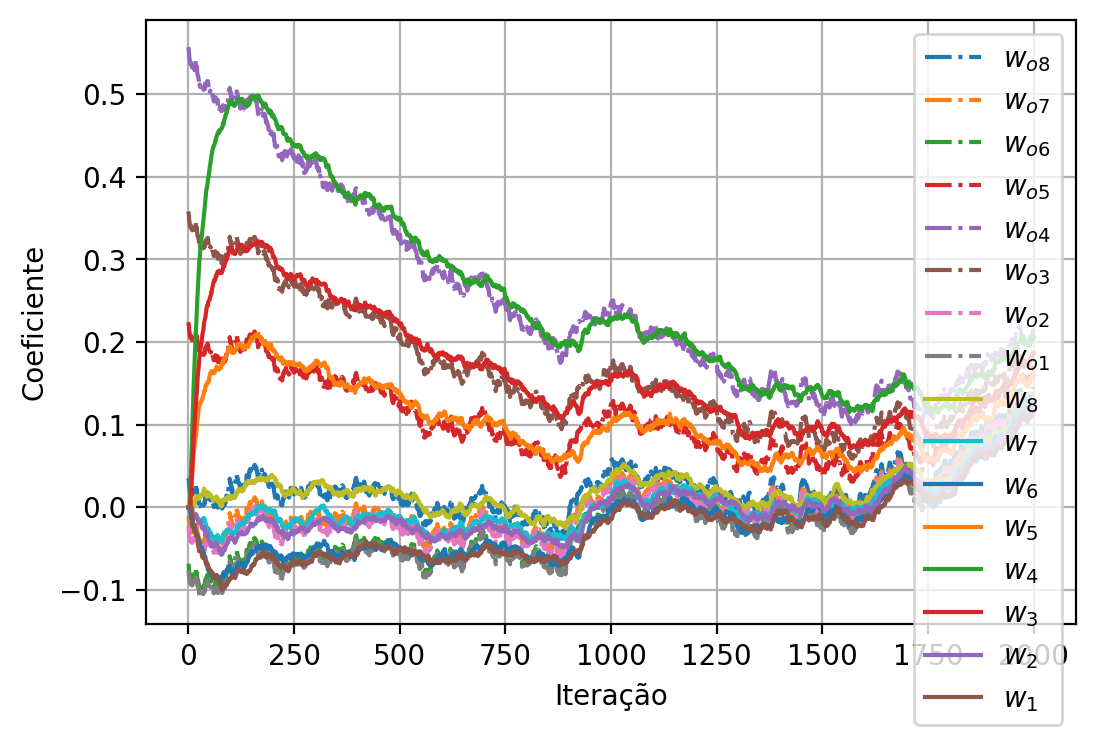

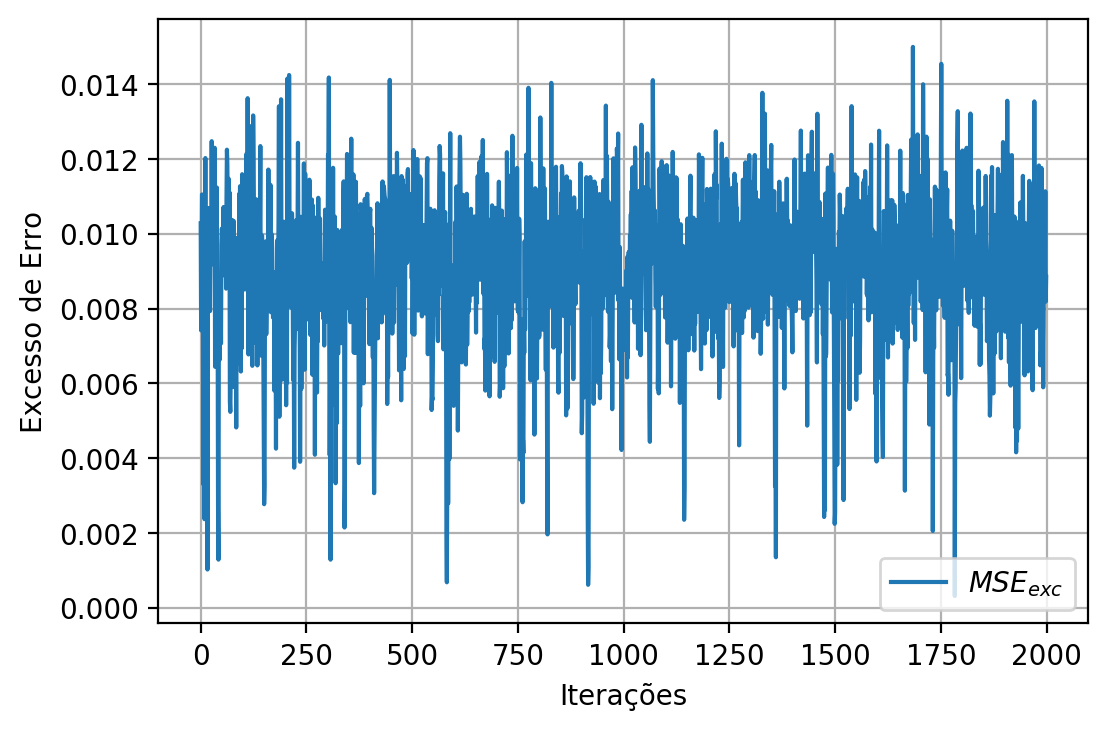

In [346]:
def train_for_mu(x, d, mu):
    errors_mean = 0
    coefficients_mean = 0
    outputs_mean = 0
    mse_min_mean = 0
    mean_wo = 0
    
    ensembles = 100

    for i in range(ensembles):
        nw = generate_noise(0, 0.001, kmax)
        wo = build_wo(wo_0, nw, kmax)
        x = generate_noise(0, 0.7, kmax)
        nd = generate_noise(0, 0.01, kmax)
        d = generate_d(x, wo, nd)
        
        w0 = np.zeros((8, 1))
        adaptive_filter = LMS(7, w0)
        results = adaptive_filter.fit(d, x, mu)

        mean_wo += wo/ensembles
        errors_mean += results['errors']/ensembles
        coefficients_mean += results['coefficients']/ensembles
        outputs_mean += results['outputs']/ensembles
        mse_min_mean += np.square(nd)/ensembles

    return mean_wo, errors_mean, coefficients_mean, outputs_mean, mse_min_mean

mean_wo, errors_mean3, coefficients_mean3, outputs_mean3, mse_min_mean3 = train_for_mu(x, d, 0.05)

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

for i in range(8):
        index = 8 - i
        ax.plot(mean_wo[i, :], label='$w_{o%i}$' % index, linestyle='-.')
for i in range(8):
        index = 8 - i
        ax.plot(coefficients_mean3[i, :], label='$w_{%i}$' % index)
        
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
fig.savefig('lista2_16a2.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

mse_exc = np.zeros(kmax)
for k in range(kmax):
    mse_exc[k] = np.abs(np.square(errors_mean3)[k] - mse_min_mean3[k])

ax.plot(mse_exc, label='$MSE_{exc}$')
ax.grid(True)
ax.legend()
ax.set_xlabel('Iterações')
ax.set_ylabel('Excesso de Erro')
fig.savefig('lista2_16a3.pdf', bbox_inches = 'tight')


### Item b

Para $\mu = 0.01$

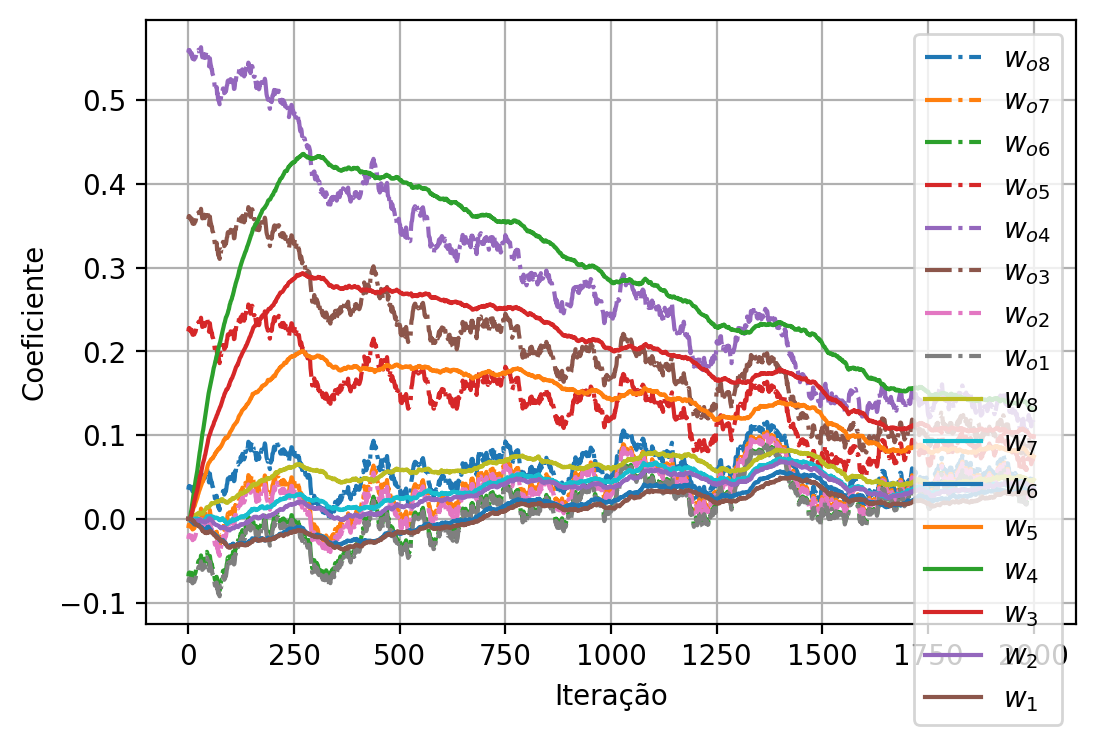

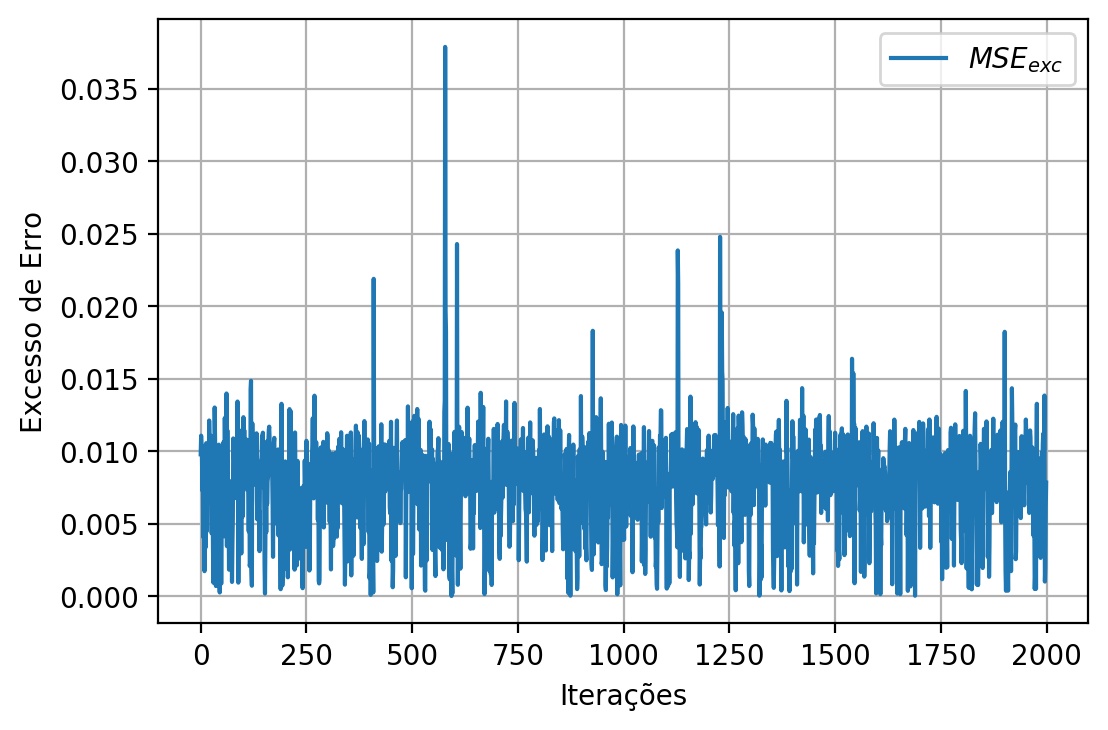

In [347]:
mean_wo, errors_mean3, coefficients_mean3, outputs_mean3, mse_min_mean3 = train_for_mu(x, d, 0.01)

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

for i in range(8):
        index = 8 - i
        ax.plot(mean_wo[i, :], label='$w_{o%i}$' % index, linestyle='-.')
for i in range(8):
        index = 8 - i
        ax.plot(coefficients_mean3[i, :], label='$w_{%i}$' % index)
        
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
fig.savefig('lista2_16b1.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

mse_exc = np.zeros(kmax)
for k in range(kmax):
    mse_exc[k] = np.abs(np.square(errors_mean3)[k] - mse_min_mean3[k])

ax.plot(mse_exc, label='$MSE_{exc}$')
ax.grid(True)
ax.legend()
ax.set_xlabel('Iterações')
ax.set_ylabel('Excesso de Erro')
fig.savefig('lista2_16b1.pdf', bbox_inches = 'tight')

Observa-se dificuldade do filtro para acompanhar as mudanças de $\vec{w_o}$ por conta do $\mu$ pequeno.

### Item c

Para $\mu = \mu_{opt} = 0.17857142857142858$

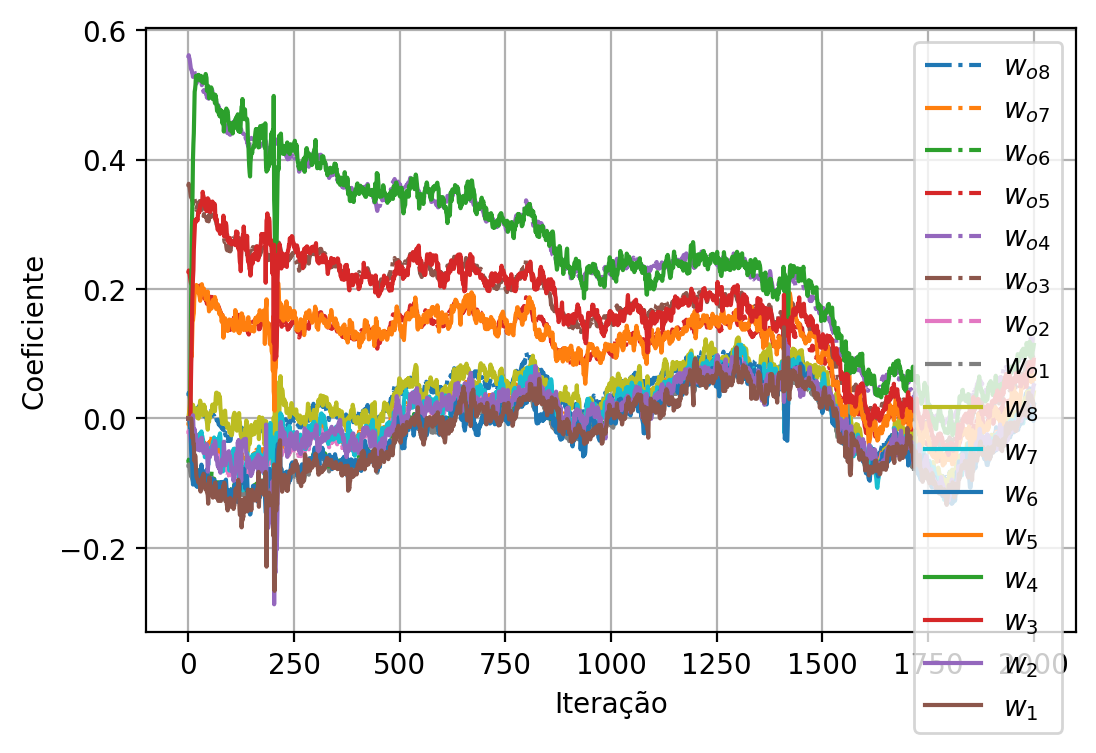

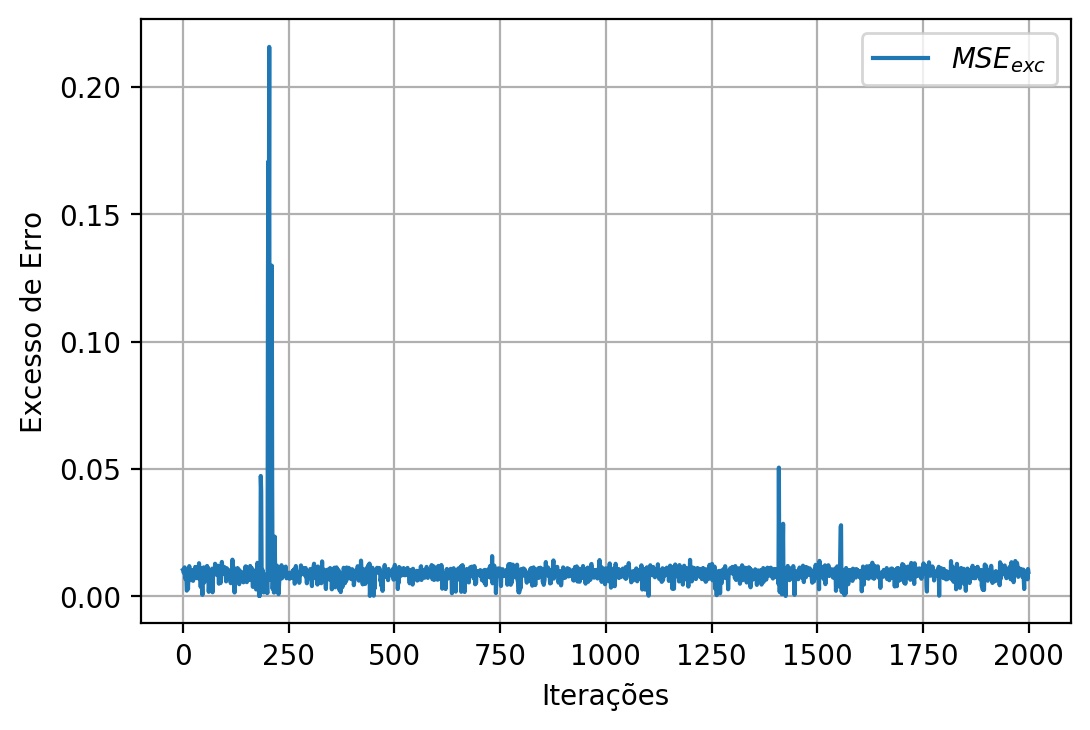

In [352]:
mean_wo, errors_mean3, coefficients_mean3, outputs_mean3, mse_min_mean3 = train_for_mu(x, d, 0.18898223650461363)

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

for i in range(8):
        index = 8 - i
        ax.plot(mean_wo[i, :], label='$w_{o%i}$' % index, linestyle='-.')
for i in range(8):
        index = 8 - i
        ax.plot(coefficients_mean3[i, :], label='$w_{%i}$' % index)
        
ax.grid(True)
ax.legend()
ax.set_xlabel('Iteração')
ax.set_ylabel('Coeficiente')
fig.savefig('lista2_16c1.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

mse_exc = np.zeros(kmax)
for k in range(kmax):
    mse_exc[k] = np.abs(np.square(errors_mean3)[k] - mse_min_mean3[k])

ax.plot(mse_exc, label='$MSE_{exc}$')
ax.grid(True)
ax.legend()
ax.set_xlabel('Iterações')
ax.set_ylabel('Excesso de Erro')
fig.savefig('lista2_16b1.pdf', bbox_inches = 'tight')

Observa-se que, apesar de em geral rastrear $\vec{w_o}$, ocorrem pontos de instabilidade.

## Questão 10

A resposta ao impulso do sistema a ser equalizado é dada por 

$$h(k) = ku(k) - (2k-9)u(k-5) + (k-9)u(k-10)$$

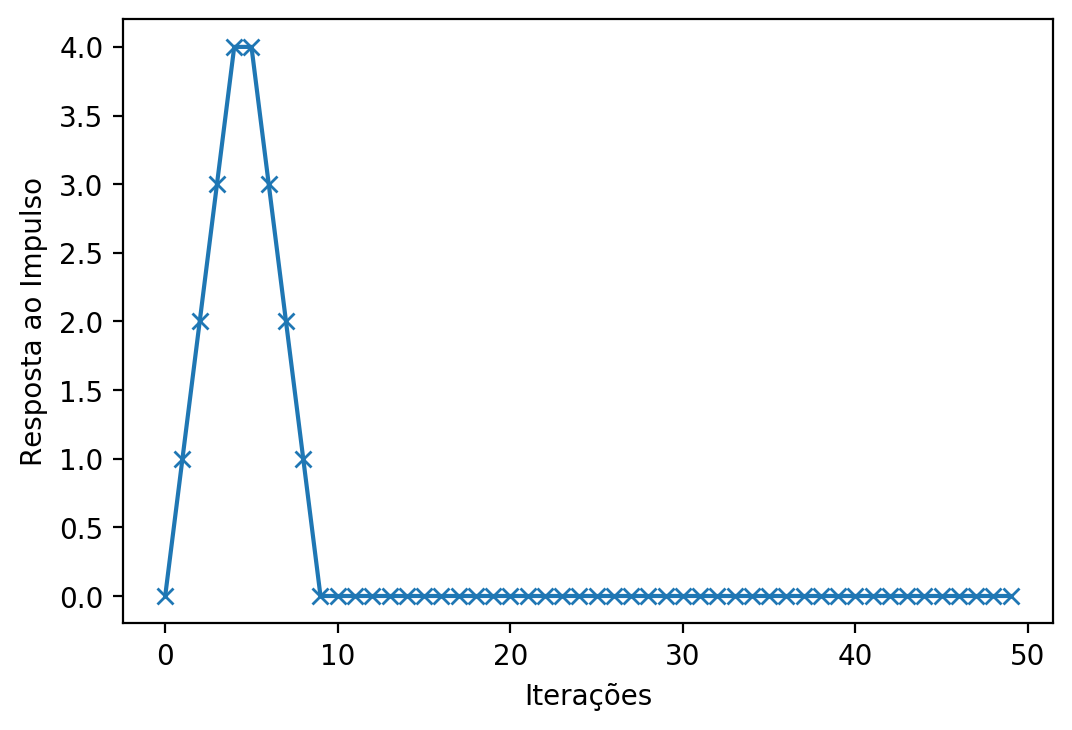

In [497]:
def u(k, lag):
    if k >= lag: return 1
    return 0

def h_k(k):
    return k * u(k, 0) - (2*k - 9) * u(k, 5) + (k - 9) * u(k, 10)

def build_h(size):
    h = np.zeros(size)
    for k in range(size):
        h[k] = h_k(k)
    return h

kmax = 50
h = build_h(kmax)

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

ax.plot(h, '-x')
ax.set_xlabel('Iterações')
ax.set_ylabel('Resposta ao Impulso')
fig.savefig('lista2_10a1.pdf', bbox_inches = 'tight')

A entrada do sistema e sinal desejado será dado por

$$x(k) = sign(n(k))$$

Em que $n(k)$ é um ruído branco. A saída do sistema é dada por

$$y(k) = h(k) * x(k) + n_2(k)$$

Em que $n(k)$ e $n_2(k)$ são descorrelacionados.

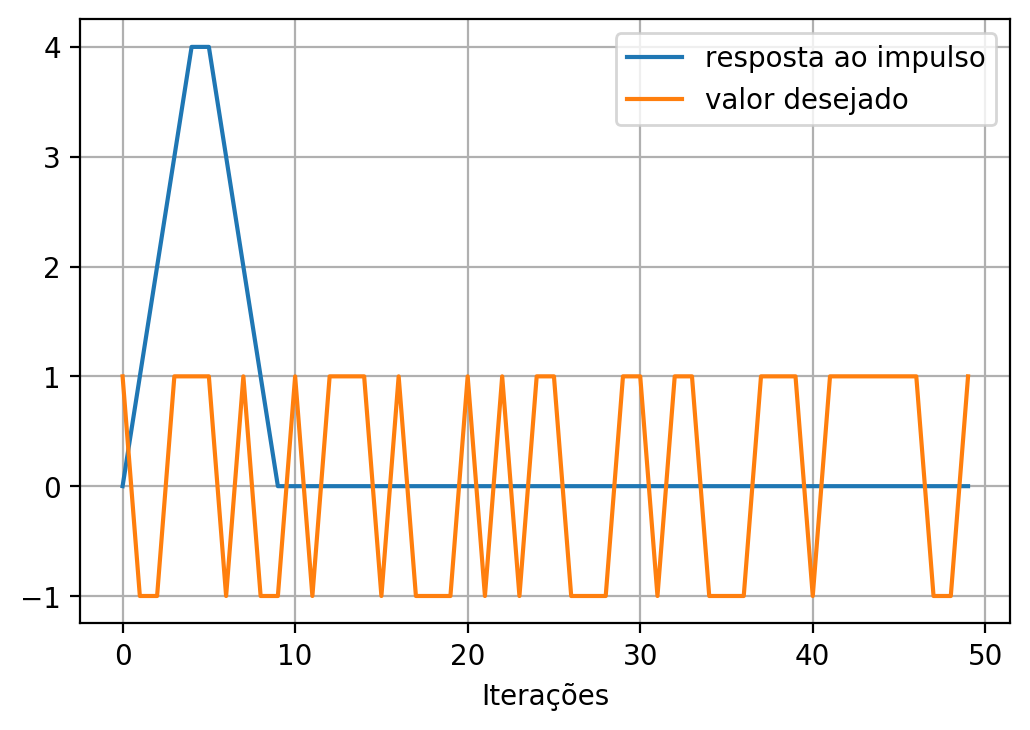

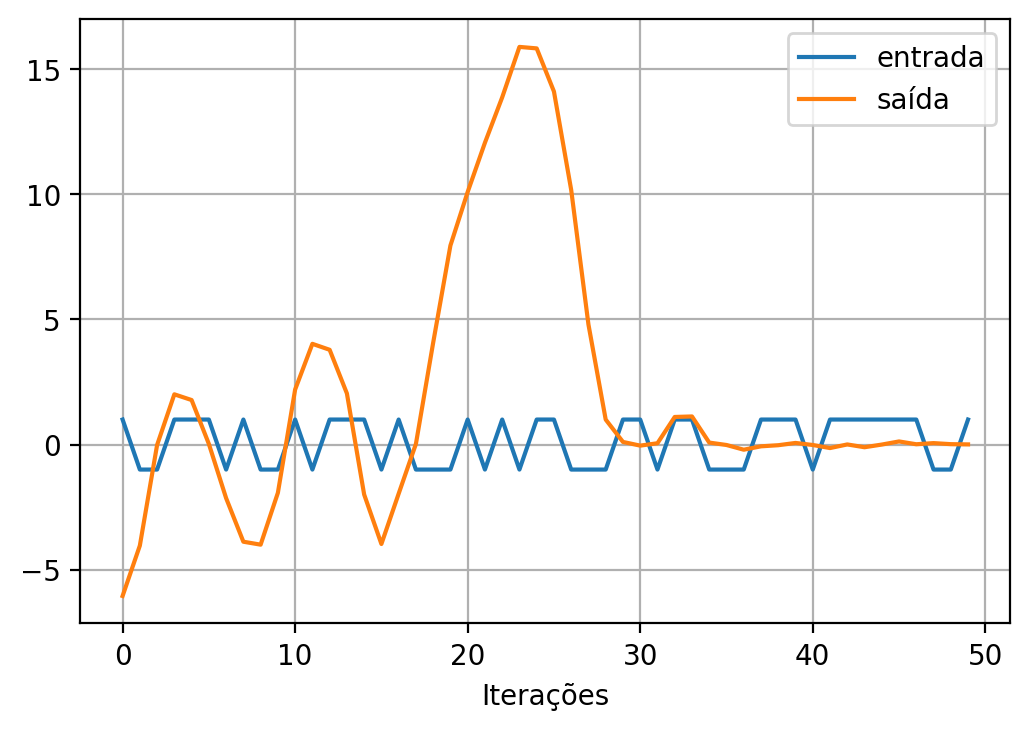

In [371]:
kmax = 50

n1 = generate_noise(0, 1, kmax)
x = np.sign(n1)

n2 = generate_noise(0, 0.01, kmax)
y = np.convolve(h, x, 'same') + n2

d = x

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

ax.plot(h, label='resposta ao impulso')
ax.plot(d, label='valor desejado')
ax.grid(True)
ax.legend()
ax.set_xlabel('Iterações')
fig.savefig('lista2_10a2.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

ax.plot(x, label='entrada')
ax.plot(y, label='saída')
ax.grid(True)
ax.legend()
ax.set_xlabel('Iterações')
fig.savefig('lista2_10a3.pdf', bbox_inches = 'tight')

Para encontrar uma cota superior para $\mu$ pode-se estimar R por meio de 100 realizações usando a relação

$$0 < \mu < \frac{1}{tr[\hat{R}]}$$

In [407]:
kmax = 100
ensembles = 1000

estR = 0
for i in range(ensembles):
    n1 = generate_noise(0, 1, kmax)
    x = np.sign(n1)
    estR += np.dot(np.transpose([x]), [x])/ensembles

mu_max = 1/np.trace(estR)
print('mu máximo: ', mu_max)

mu máximo:  0.009999999999999995


Inicia-se agora o treinamento do filtro, com $\mu = 0.005$

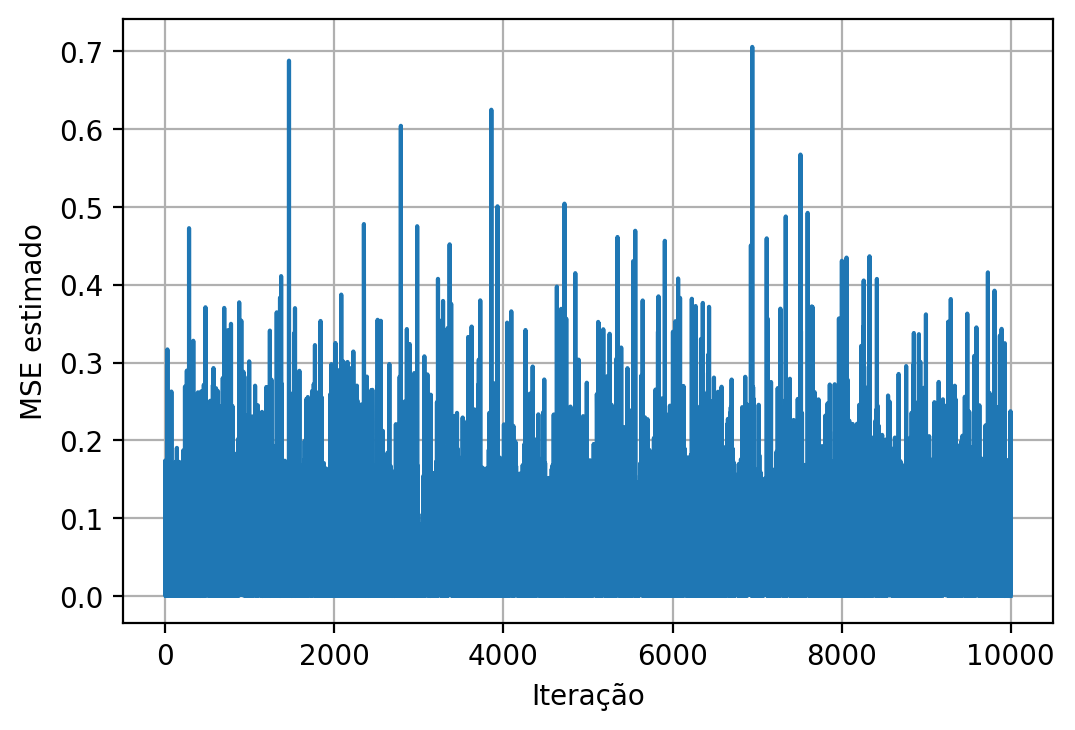

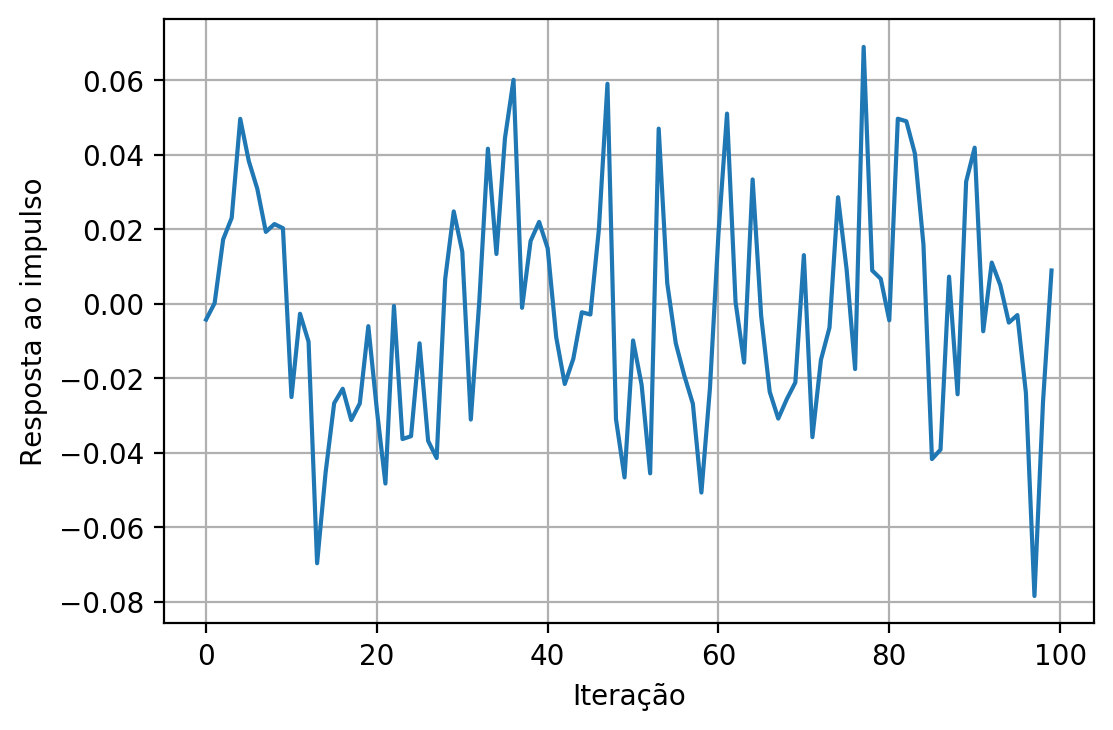

In [587]:
def train_ex_10(h, mu, kmax):
    errors_mean = 0
    coefficients_mean = 0
    outputs_mean = 0
    
    ensembles = 20
    for i in range(ensembles):
        h = build_h(kmax)
        
        n1 = generate_noise(0, .01, kmax)
        x = np.sign(n1)

        n2 = generate_noise(0, 0.01, kmax)
        
        a = [1]
        b = [0, 1, 1, 1, 1, 0, 4, 6, 8, 10, 12]
        y = signal.lfilter(b, a, x)
        
        ybar = (y-np.mean(y))/np.var(y)

        d = x + n2
        
        filter_order = 99
        w0 = np.zeros((filter_order + 1, 1))
        
        adaptive_filter = LMS(filter_order, w0)
        results = adaptive_filter.fit(d, ybar, mu)

        errors_mean += results['errors']/ensembles
        coefficients_mean += results['coefficients']/ensembles
        outputs_mean += results['outputs']/ensembles

    return errors_mean, coefficients_mean, outputs_mean

errors_mean3, coefficients_mean3, outputs_mean3 = train_ex_10(h, 0.05, 1000)

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

ax.plot(np.square(errors_mean3))
        
ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('MSE estimado')
fig.savefig('lista2_10a3.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)

ax.plot(coefficients_mean3[:, -1])
ax.grid(True)
ax.set_xlabel('Iteração')
ax.set_ylabel('Resposta ao impulso')
fig.savefig('lista2_10a4.pdf', bbox_inches = 'tight')



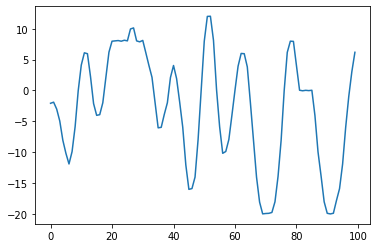

In [557]:
kmax =  100
h = build_h(10)

n1 = generate_noise(0, 1, kmax)
x = np.sign(n1)

n2 = generate_noise(0, 0.01, kmax)
y = np.convolve(h, x, 'same') + n2
plt.plot(y)

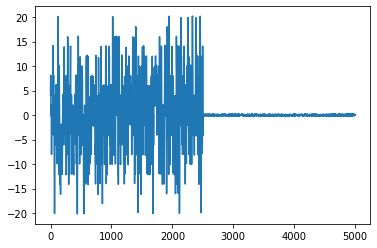

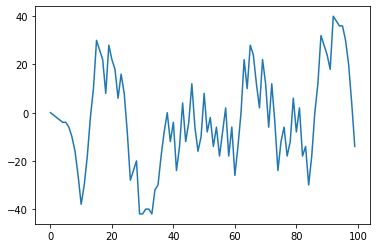

In [584]:
n1 = generate_noise(0, .01, 1000)
x = np.sign(n1)
a = [1]
b = [0, 1, 1, 1, 1, 0, 4, 6, 8, 10, 12]
y = signal.lfilter(b, a, x)
plt.plot(y)